# Data Insider JC

## Setting up the environment

In [ ]:
!pip install polygon-api-client
!pip install bar_chart_race
!pip install colab-env -qU

In [ ]:
from google.colab import drive
from polygon import RESTClient
import numpy as np
import pandas as pds
import matplotlib.pyplot as mpl
import seaborn as sb
import plotly.graph_objects as pgo
import bar_chart_race as rbc
import os
import colab_env
#from colab_env import envvar_handler

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Getting Data

### Forbes 2000 from 2015 to 2022

https://data.world/aroissues/forbes-global-2000-2008-2019

In [ ]:
data_2015 = pds.read_excel('/content/gdrive/MyDrive/data-ins/forbes_2000-2008-2019_aroissues_data-world/Forbes Global 2000 - 2015 — unified industry.xlsx')

data_2016 = pds.read_excel('/content/gdrive/MyDrive/data-ins/forbes_2000-2008-2019_aroissues_data-world/Forbes Global 2000 - 2016 — unified industry.xlsx')

data_2017 = pds.read_excel('/content/gdrive/MyDrive/data-ins/forbes_2000-2008-2019_aroissues_data-world/Forbes Global 2000 - 2017 — unified industry.xlsx')

data_2018 = pds.read_excel('/content/gdrive/MyDrive/data-ins/forbes_2000-2008-2019_aroissues_data-world/Forbes Global 2000 - 2018 — unified industry.xlsx')

data_2019 = pds.read_excel('/content/gdrive/MyDrive/data-ins/forbes_2000-2008-2019_aroissues_data-world/Forbes Global 2000 - 2019 — unified industry.xlsx')

data_2020 = pds.read_excel('/content/gdrive/MyDrive/data-ins/forbes_2000-2008-2019_aroissues_data-world/Forbes Global 2000 - 2020 — unified industry.xlsx')

data_2021 = pds.read_excel('/content/gdrive/MyDrive/data-ins/forbes_2000-2008-2019_aroissues_data-world/Forbes Global 2000 - 2021 — unified industry.xlsx')

data_2022 = pds.read_excel('/content/gdrive/MyDrive/data-ins/forbes_2000-2008-2019_aroissues_data-world/Forbes Global 2000 - 2022 — unified industry.xlsx')

In [ ]:
data_2015.head(7)
data_2018.head(7)
data_2022.head(7)

Rank_nr                                   Company  \
0       1                        Berkshire Hathaway   
1       2                                      ICBC   
2       3  Saudi Arabian Oil Company (Saudi Aramco)   
3       4                            JPMorgan Chase   
4       5                   China Construction Bank   
5       6                                    Amazon   
6       7                                     Apple   

                          Industry        Country   Sales   Profits   Assets  \
0           Diversified Financials  United States  276094   89795.0   958784   
1                          Banking          China  208127   54028.3  5518508   
2             Oil & Gas Operations   Saudi Arabia  400376  105363.0   576041   
3           Diversified Financials  United States  124542   42115.0  3954687   
4                          Banking          China  202069   46887.3  4746951   
5                        Retailing  United States  469822   33364.0   420549   
6  Technology Hardware & Equipment  United States  378697  100555.0   381191   

   Market_Value  
0        741476  
1        214425  
2       2292077  
3        374446  
4        181325  
5       1468398  
6       2640316

### Polygon API

Get the historical data of shares (stocks) of 5 companies between January 1 and December 31, 2022.
5 different datasets are created. The variables that are needed (stored) are: The Symbol, The Date, and The Open, Close, Maximum and Minimum Prices of the shares (stocks).

In [ ]:
# colab_env.envvar_handler.add_env("api_key", 'my-api-key', overwrite=True)

In [ ]:
client = RESTClient(os.getenv("api_key"))

In [ ]:
def rstClt(tkr, data_name):
  aggs = client.get_aggs(tkr, 1,
                         "day",
                         "2022-01-01",
                         "2022-12-31")

  data_name = pds.DataFrame(aggs)
  data_name['datetime'] = pds.to_datetime(data_name['timestamp'], unit='ms')
  data_name['symbol'] = tkr

  data_name_hist = f'{data_name}_data_hist'
  data_name_hist = data_name[['symbol','datetime','open','high','low','close']]
  data_name_hist.to_csv(f'/content/gdrive/MyDrive/data-ins_2/company_history_2/{tkr}_historical_data.csv')

  return data_name_hist

In [ ]:
apple_data_hist = rstClt("AAPL", 'apple')
amazon_data_hist = rstClt("AMZN", 'amazon')
cisco_data_hist = rstClt("CSCO", 'cisco')
google_data_hist = rstClt("GOOGL", 'google')
microsoft_data_hist = rstClt("MSFT", 'microsoft')

## Data Preprocessing

### Forbes 2000 - Column names

In [ ]:
new_names = ['Nr_Ranking',"Company", "Industry", "Country",'Revenues','Earnings','Assets','Market value']

# Forbes dataframes List
dataframes = [data_2015, data_2016, data_2017, data_2018, data_2019, data_2020, data_2021, data_2022]

for i, df in enumerate(dataframes):
    df.columns = new_names
    #print(df)

### Forbes 2000 - New Variables

-Profit margin: Earnings/Revenues

-Return on assets (ROA): Earnings/Assets

-Year: According to the data

In [ ]:
dataframes = [data_2015, data_2016, data_2017, data_2018, data_2019, data_2020, data_2021, data_2022]

for i, df in enumerate(dataframes):
  r = df[df['Revenues'].isnull()].shape[0]
  e = df[df['Earnings'].isnull()].shape[0]
  a = df[df['Assets'].isnull()].shape[0]
  m = df[df['Market value'].isnull()].shape[0]
  y = i + 2015
  print(y,r,e,a,m)

2015 2 0 1 0
2016 3 1 2 2
2017 2 0 1 1
2018 1 0 4 3
2019 0 1 5 0
2020 0 0 0 0
2021 0 0 2 0
2022 0 0 0 0


In [ ]:
# Replace null data of Revenue, Earnings, Assets and Market value, with industry average
dataframes = [data_2015, data_2016, data_2017, data_2018, data_2019, data_2020, data_2021, data_2022]

for i, df in enumerate(dataframes):
  avg_revenue = df.groupby('Industry')['Revenues'].mean().round(1)
  df['Revenues'] = df.apply(lambda row: avg_revenue[row['Industry']] if pds.isnull(row['Revenues']) else row['Revenues'], axis=1)

  avg_eranings = df.groupby('Industry')['Earnings'].mean().round(1)
  df['Earnings'] = df.apply(lambda row: avg_eranings[row['Industry']] if pds.isnull(row['Earnings']) else row['Earnings'], axis=1)

  avg_assets = df.groupby('Industry')['Assets'].mean().round(1)
  df['Assets'] = df.apply(lambda row: avg_assets[row['Industry']] if pds.isnull(row['Assets']) else row['Assets'], axis=1)

  avg_market = df.groupby('Industry')['Market value'].mean().round(1)
  df['Market value'] = df.apply(lambda row: avg_market[row['Industry']] if pds.isnull(row['Market value']) else row['Market value'], axis=1)

  dataframes[i] = df

In [ ]:
# Uploaded data
dataframes = [data_2015, data_2016, data_2017, data_2018, data_2019, data_2020, data_2021, data_2022]

for i, df in enumerate(dataframes):
  r = df[df['Revenues'].isnull()].shape[0]
  e = df[df['Earnings'].isnull()].shape[0]
  a = df[df['Assets'].isnull()].shape[0]
  m = df[df['Market value'].isnull()].shape[0]
  y = i + 2015
  print(y,r,e,a,m)

2015 0 0 0 0
2016 0 0 0 0
2017 0 0 0 0
2018 0 0 0 0
2019 0 0 0 0
2020 0 0 0 0
2021 0 0 0 0
2022 0 0 0 0


In [ ]:
# Create new variables
dataframes = [data_2015, data_2016, data_2017, data_2018, data_2019, data_2020, data_2021, data_2022]

counter = 0

for i, df in enumerate(dataframes):
    # Profit margin
    df['Profit margin'] = (df['Earnings'] / df['Revenues']).round(4)
    # Return of assets
    df['ROA'] = (df['Earnings'] / df['Assets']).round(4)
    # Year
    df['Year'] = 2015 + counter
    counter += 1
    # Save data
    dataframes[i] = df


In [ ]:
data_2015.tail(7)
data_2017.tail(7)
data_2022.tail(7)

Nr_Ranking                                    Company  \
1993       1993                        Wingtech Technology   
1994       1995                                     Aperam   
1995       1995  Shenzhen Feima International Supply Chain   
1996       1997                                       NMDC   
1997       1997                 Sichuan Changhong Electric   
1998       1999                         Satellite Chemical   
1999       2000                            Sun Communities   

                             Industry        Country  Revenues  Earnings  \
1993  Technology Hardware & Equipment          China      7930     337.7   
1994                        Materials     Luxembourg      6030    1144.2   
1995     Business Services & Supplies          China        37    1408.3   
1996                        Materials          India      3520    1406.4   
1997                Consumer Durables          China     15716      53.1   
1998                        Chemicals          China      4413     931.3   
1999           Diversified Financials  United States      2273     375.7   

      Assets  Market value  Profit margin     ROA  Year  
1993   11085         12456         0.0426  0.0305  2022  
1994    6722          3159         0.1898  0.1702  2022  
1995     166          1136        38.0622  8.4837  2022  
1996    5715          6401         0.3995  0.2461  2022  
1997   12105          1957         0.0034  0.0044  2022  
1998    7640          9521         0.2110  0.1219  2022  
1999   13494         21714         0.1653  0.0278  2022

### Fortune Global 500 - Rename columns and new variable year

In [ ]:
# Upload data from Fortune Global 500
data_fg_pre_2015 = pds.read_html('/content/gdrive/MyDrive/data-ins/fortune_500_global/fortune_global_2015.html')
data_fg_2015=data_fg_pre_2015[0]

data_fg_pre_2016 = pds.read_html('/content/gdrive/MyDrive/data-ins/fortune_500_global/fortune_global_2016.html')
data_fg_2016=data_fg_pre_2016[0]

data_fg_pre_2017 = pds.read_html('/content/gdrive/MyDrive/data-ins/fortune_500_global/fortune_global_2017.html')
data_fg_2017=data_fg_pre_2017[0]

data_fg_pre_2018 = pds.read_html('/content/gdrive/MyDrive/data-ins/fortune_500_global/fortune_global_2018.html')
data_fg_2018=data_fg_pre_2018[0]

data_fg_pre_2019 = pds.read_html('/content/gdrive/MyDrive/data-ins/fortune_500_global/fortune_global_2019.html')
data_fg_2019=data_fg_pre_2019[0]

data_fg_pre_2020 = pds.read_html('/content/gdrive/MyDrive/data-ins/fortune_500_global/fortune_global_2020.html')
data_fg_2020=data_fg_pre_2020[0]

data_fg_pre_2021 = pds.read_html('/content/gdrive/MyDrive/data-ins/fortune_500_global/fortune_global_2021.html')
data_fg_2021=data_fg_pre_2021[0]

data_fg_pre_2022 = pds.read_html('/content/gdrive/MyDrive/data-ins/fortune_500_global/fortune_global_2022.html')
data_fg_2022=data_fg_pre_2022[0]

In [ ]:
# Get only two columns, the ones for analytical purposes
desired_columns = ['RemoveName','RemoveEmployees']
data_fg_2015 = data_fg_2015[desired_columns]
data_fg_2016 = data_fg_2016[desired_columns]
data_fg_2017 = data_fg_2017[desired_columns]
data_fg_2018 = data_fg_2018[desired_columns]
data_fg_2019 = data_fg_2019[desired_columns]
data_fg_2020 = data_fg_2020[desired_columns]
data_fg_2021 = data_fg_2021[desired_columns]
data_fg_2022 = data_fg_2022[desired_columns]

In [ ]:
# Rename variables
names_new = ['Company',"Employees"]

dataframes = [data_fg_2015, data_fg_2016, data_fg_2017, data_fg_2018, data_fg_2019, data_fg_2020, data_fg_2021, data_fg_2022]

for i, df in enumerate(dataframes):
    df.columns = names_new
    #print(df)

In [ ]:
# Uploaded data list
dataframes = [data_fg_2015, data_fg_2016, data_fg_2017, data_fg_2018, data_fg_2019, data_fg_2020, data_fg_2021, data_fg_2022]

counter = 0

for i, df in enumerate(dataframes):
    df['Year'] = 2015 + counter
    counter += 1
    # Save
    dataframes[i] = df

<ipython-input-19-baffa485c7f5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = 2015 + counter
<ipython-input-19-baffa485c7f5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = 2015 + counter
<ipython-input-19-baffa485c7f5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

### Country code and Continents

In [ ]:
# Upload data
data_country= pds.read_csv('/content/gdrive/MyDrive/data-ins/continents_and_countries/country_code.csv')
data_continent = pds.read_csv('/content/gdrive/MyDrive/data-ins/continents_and_countries/continents.csv')

In [ ]:
data_country.head()

Country Code
0     Afghanistan  AFG
1         Albania  ALB
2         Algeria  DZA
3  American Samoa  ASM
4         Andorra  AND

In [ ]:
data_continent = data_continent[['Country_Name','Three_Letter_Country_Code','Continent_Name']]
data_continent = data_continent.rename(columns={'Three_Letter_Country_Code':'Code'})
data_continent.tail()

Country_Name Code Continent_Name
253  Venezuela, Bolivarian Republic of  VEN  South America
254                  Wallis and Futuna  WLF        Oceania
255        Samoa, Independent State of  WSM        Oceania
256                              Yemen  YEM           Asia
257                Zambia, Republic of  ZMB         Africa

## EDA

*Getting the continent*

In [ ]:
# Add Continent to Country dataframe
data_country_cont = pds.merge(data_country, data_continent[['Code','Continent_Name']], on='Code', how = 'left')
data_country_cont.tail()

Country Code Continent_Name
224  Virgin Islands  VGB  North America
225       West Bank  WBG            NaN
226           Yemen  YEM           Asia
227          Zambia  ZMB         Africa
228        Zimbabwe  ZWE         Africa

In [ ]:
data_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Country  222 non-null    object
 1   Code     222 non-null    object
dtypes: object(2)
memory usage: 3.6+ KB


In [ ]:
data_country_cont.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229 entries, 0 to 228
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Country         229 non-null    object
 1   Code            229 non-null    object
 2   Continent_Name  226 non-null    object
dtypes: object(3)
memory usage: 7.2+ KB


In [ ]:
data_country_cont[data_country_cont['Continent_Name'].isnull()]

Country Code Continent_Name
16   Bahamas, The  BHM            NaN
114        Kosovo  KSV            NaN
225     West Bank  WBG            NaN

In [ ]:
lkf = data_continent.query("Country_Name.str.contains('Koso') or Country_Name.str.contains('Baha')")
lkf

Country_Name Code Continent_Name
13  Bahamas, Commonwealth of the  BHS  North America

- It is validated that Bahamas should have a three-digit BHS code
- The country Kosovo was not found, so the continent will remain null
- West Bank is not a country but a bank, so the continent will be null

In [ ]:
# Search Bahamas in Country Data
lkf = data_country[data_country['Country'].str.contains('Baha')]
lkf

Country Code
14  Bahamas, The  BHM

In [ ]:
# Modify the original data (Data Country), the row 14 of Bahamas with code BHM instead of BHS
data_country.at[14, 'Code'] = 'BHS'

# Join again to obtain the continent for the Country Data
data_country_cont = pds.merge(data_country, data_continent[['Code','Continent_Name']], on='Code', how = 'left')

In [ ]:
country_count = data_country_cont['Country'].value_counts()

# Filter original DataFrame using 'country_count > 1'
df_skmd = data_country_cont[data_country_cont['Country'].isin(country_count[country_count > 1].index)]
df_skmd

Country Code Continent_Name
9       Armenia  ARM         Europe
10      Armenia  ARM           Asia
14   Azerbaijan  AZE         Europe
15   Azerbaijan  AZE           Asia
55       Cyprus  CYP         Europe
56       Cyprus  CYP           Asia
77      Georgia  GEO         Europe
78      Georgia  GEO           Asia
108  Kazakhstan  KAZ         Europe
109  Kazakhstan  KAZ           Asia
169      Russia  RUS         Europe
170      Russia  RUS           Asia
210      Turkey  TUR         Europe
211      Turkey  TUR           Asia

In [ ]:
# Remove those columns that are duplicated
duplicated_columns = ['Country','Code']
data_country_cont = data_country_cont.drop_duplicates(subset = duplicated_columns)

In [ ]:
data_country_cont.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 222 entries, 0 to 228
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Country         222 non-null    object
 1   Code            222 non-null    object
 2   Continent_Name  220 non-null    object
dtypes: object(3)
memory usage: 6.9+ KB


*Join forbes 2000-2022 and Data Country*

In [ ]:
data_2022_cont = pds.merge(data_2022, data_country_cont[['Country','Code','Continent_Name']], on='Country', how = 'left')

In [ ]:
data_2022_cont.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Nr_Ranking      2000 non-null   object 
 1   Company         2000 non-null   object 
 2   Industry        2000 non-null   object 
 3   Country         2000 non-null   object 
 4   Revenues        2000 non-null   int64  
 5   Earnings        2000 non-null   float64
 6   Assets          2000 non-null   int64  
 7   Market value    2000 non-null   int64  
 8   Profit margin   2000 non-null   float64
 9   ROA             2000 non-null   float64
 10  Year            2000 non-null   int64  
 11  Code            1934 non-null   object 
 12  Continent_Name  1934 non-null   object 
dtypes: float64(3), int64(4), object(6)
memory usage: 218.8+ KB


*Check null in Countries*

In [ ]:
data_2022_null = data_2022_cont[data_2022_cont['Code'].isnull()]
data_2022_null['Country'].unique()

array(['South Korea', 21274], dtype=object)

- It is validated that the country South Korea is not matching with the country of the data country
- It is validated that there is a country 21274, in this case it is not a country

*Modify the name to South Korea*

In [ ]:
data_country_cont.query("Country.str.contains('Korea')")

Country Code Continent_Name
112  Korea, North  PRK           Asia
113  Korea, South  KOR           Asia

In [ ]:
data_country_cont.at[113, 'Country'] = 'South Korea'

In [ ]:
data_2022_cont = pds.merge(data_2022, data_country_cont[['Country','Code','Continent_Name']], on='Country', how = 'left')

In [ ]:
# Validte that the dataset has the amount of 2000 rows
dataframes = [data_2015, data_2016, data_2017, data_2018, data_2019, data_2020, data_2021, data_2022]

for i, df in enumerate(dataframes):
  s = df.shape[0]
  y = i + 2015
  print(y,s)

2015 2000
2016 1999
2017 1999
2018 2000
2019 2000
2020 2000
2021 2000
2022 2000


In [ ]:
# Validate if the Nr_Ranking has duplicate values
data_2016.head(10)

Nr_Ranking                     Company                         Industry  \
0           1                        ICBC                          Banking   
1           2     China Construction Bank                          Banking   
2           3  Agricultural Bank of China                          Banking   
3           4          Berkshire Hathaway           Diversified Financials   
4           5              JPMorgan Chase                          Banking   
5           6               Bank of China                          Banking   
6           7                 Wells Fargo                          Banking   
7           8                       Apple  Technology Hardware & Equipment   
8           9                  ExxonMobil             Oil & Gas Operations   
9          10                Toyota Motor                Consumer Durables   

         Country  Revenues  Earnings     Assets  Market value  Profit margin  \
0          China  171077.0   44160.3  3420257.0      198042.0         0.2581   
1          China  146816.0   36393.4  2825983.0      162774.0         0.2479   
2          China  131888.0   28808.7  2739835.0      152736.0         0.2184   
3  United States  210821.0   24083.0   561068.0      360145.0         0.1142   
4  United States   99881.0   23548.0  2423808.0      234247.0         0.2358   
5          China  122027.0   27209.5  2589605.0      143002.0         0.2230   
6  United States   91431.0   22686.0  1849182.0      255998.0         0.2481   
7  United States  233273.0   53731.0   293284.0      585951.0         0.2303   
8  United States  236810.0   16150.0   336758.0      363270.0         0.0682   
9          Japan  235832.0   19267.0   406692.0      176960.0         0.0817   

      ROA  Year  
0  0.0129  2016  
1  0.0129  2016  
2  0.0105  2016  
3  0.0429  2016  
4  0.0097  2016  
5  0.0105  2016  
6  0.0123  2016  
7  0.1832  2016  
8  0.0480  2016  
9  0.0474  2016

In [ ]:
# Modify the Nr_Ranking of all datasets
dataframes = [data_2015, data_2016, data_2017, data_2018, data_2019, data_2020, data_2021, data_2022]

for i, df in enumerate(dataframes):
  new_ranking = [i + 1 for i in range(len(df))]
  df['Nr_Ranking'] = new_ranking
  dataframes[i] = df

In [ ]:
# data_forbes will have 15998 rows because the 2016 and 2017 data have only 1999 rows
data_forbes = pds.concat([data_2015, data_2016, data_2017, data_2018, data_2019, data_2020, data_2021, data_2022])

In [ ]:
# Join the forbes data to country data
data_forbes_def = pds.merge(data_forbes, data_country_cont[['Country','Code','Continent_Name']], on='Country', how = 'left')

In [ ]:
# Validte 2 null values due to country is a number
data_forbes_def[data_forbes_def['Code'].isnull()]

Nr_Ranking                         Company                Industry  \
13467        1470  fred/companies/F2K/2021/105837  IT Software & Services   
14733         736  fred/companies/F2K/2022/105837  IT Software & Services   

      Country  Revenues  Earnings   Assets  Market value  Profit margin  \
13467    5855   68126.0    1793.0  26718.4         235.0         0.0263   
14733   21274   28636.0     370.0   1468.0         632.0         0.0129   

          ROA  Year Code Continent_Name  
13467  0.0671  2021  NaN            NaN  
14733  0.2520  2022  NaN            NaN

In [ ]:
# Validate if all datasets have the amount of 500 rows
dataframes = [data_fg_2015,data_fg_2016,data_fg_2017,data_fg_2018,data_fg_2019,data_fg_2020,data_fg_2021,data_fg_2022]

for i, df in enumerate(dataframes):
  s = df.shape[0]
  y = i + 2015
  print(y,s)

2015 500
2016 500
2017 500
2018 501
2019 500
2020 500
2021 500
2022 500


In [ ]:
# In the previous script it's validated that the 2018 data has one more row
company_count = data_fg_2018['Company'].value_counts()

# Filter the original DataFrame using 'company_count > 1'
df_skmmd = data_fg_2018[data_fg_2018['Company'].isin(company_count[company_count > 1].index)]
df_skmmd

Company  Employees  Year
235    KDDI      38826  2018
236    KDDI      38826  2018

In [ ]:
# Remove duplicates
data_fg_2018=data_fg_2018.drop_duplicates()

In [ ]:
# Validate again
dataframes = [data_fg_2015,data_fg_2016,data_fg_2017,data_fg_2018,data_fg_2019,data_fg_2020,data_fg_2021,data_fg_2022]

for i, df in enumerate(dataframes):
  s = df.shape[0]
  y = i + 2015
  print(y,s)

2015 500
2016 500
2017 500
2018 500
2019 500
2020 500
2021 500
2022 500


In [ ]:
# Join fortune global tables from 2015 to 2022
data_fg_total = pds.concat([data_fg_2015,data_fg_2016,data_fg_2017,data_fg_2018,data_fg_2019,data_fg_2020,data_fg_2021,data_fg_2022])
data_fg_total.shape[0]

4000

In [ ]:
# Join forbes to country data
data_def = pds.merge(data_forbes_def, data_fg_total[['Year','Company','Employees']], on=['Year','Company'], how = 'left')

In [ ]:
data_def.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15998 entries, 0 to 15997
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Nr_Ranking      15998 non-null  int64  
 1   Company         15998 non-null  object 
 2   Industry        15998 non-null  object 
 3   Country         15998 non-null  object 
 4   Revenues        15998 non-null  float64
 5   Earnings        15998 non-null  float64
 6   Assets          15998 non-null  float64
 7   Market value    15998 non-null  float64
 8   Profit margin   15998 non-null  float64
 9   ROA             15998 non-null  float64
 10  Year            15998 non-null  int64  
 11  Code            15996 non-null  object 
 12  Continent_Name  15996 non-null  object 
 13  Employees       2205 non-null   float64
dtypes: float64(7), int64(2), object(5)
memory usage: 1.8+ MB


In [ ]:
data_fg_total.loc[data_fg_total["Company"] == "China Mobile Communications", "Company"] = "Volkswagen Group"
data_fg_total.loc[data_fg_total["Company"] == "Volkswagen", "Company"] = "China Mobile"
data_fg_total.loc[data_fg_total["Company"] == "Walmart", "Company"] = "Wal-Mart Stores"

## Data Query and Visualizations


### Chart Functions

In [ ]:
#1. What is the Top 10 countries with the most companies in Forbes for the indicated period (2000 - 2022)?
#1. What is the Top 10 countries with the most companies in Forbes for the indicated period (2015 - 2022)?

def top_10_countries(data, sbtitle):

  top_10_countries_fbs = data['Country'].value_counts().head(10).index

  mpl.figure(figsize=(15, 8))

  ax=sb.countplot(data=data,
                  y='Country',
                  order=top_10_countries_fbs,
                  palette='flare',
                  saturation=0.75,
                  width=0.8)

  ax.set_xticklabels([])
  mpl.suptitle('Top 10 countries with the most companies in Forbes',fontsize=20,weight='bold')
  mpl.title(sbtitle,fontsize=15,pad=15)
  mpl.ylabel('')
  mpl.xlabel('')

  for p in ax.patches:
      width = p.get_width()
      value = p.get_width()
      x = p.get_x() + width + 5
      y = p.get_y() + p.get_height() / 2
      ax.annotate(value, (x, y), xytext=(5, 0), textcoords='offset points')

  mpl.show()

In [ ]:
#2. What is the Top 4 countries with the most companies in the area of technology and telecommunications?
#2. What is the Top 5 countries with the most companies in the area of technology and telecommunications?

def top_telecom(data, qty, sptitle, sbtitle):

  top_telecom_fbs = data[data['Industry'].isin(['Telecommunications Services','Technology Hardware & Equipment'])]['Country'].value_counts().head(qty)

  mpl.figure(figsize=(15, 8))

  ax=sb.barplot(x=top_telecom_fbs.index,
                y=top_telecom_fbs.values,
                palette='flare',
                saturation=0.75,
                width=0.8)

  mpl.suptitle(sptitle,fontsize=20,weight='bold')
  mpl.title(sbtitle,fontsize=15,pad=15)
  mpl.ylabel('Quantity')
  mpl.xlabel('Country')

  for i, v in enumerate(top_telecom_fbs.values):
      ax.text(i, v, str(v), ha='center', va='bottom', fontsize=10)

  mpl.show()

In [ ]:
#5. Which were the North American companies with the highest percentage of profitability by industry?
#5. Which were the European companies with the highest percentage of profitability by industry?
"""
Obtain companies and leave those with a profitability margin < 100
since there are companies that have 406% or 151900% and that's uncommon for a profit margin
"""

def top_companies_eu_na(data, continent, sptitle, sbtitle):

  top_companies = data[(data['Continent_Name']==continent)&(data['Profit margin']<1)]

  profitability_icrsd = top_companies.groupby('Industry')['Profit margin'].idxmax()
  profitability_company = top_companies.loc[profitability_icrsd, ['Industry', 'Company', 'Profit margin']]
  profitability_company['%_profitability'] = (profitability_company['Profit margin']*100)

  mpl.figure(figsize=(15, 8))

  profitability_sorted = profitability_company.sort_values('%_profitability', ascending=False)

  ax=sb.barplot(data=profitability_sorted,
                x='%_profitability',
                y='Company',
                hue='Industry',
                dodge=False,
                palette='flare')

  ax.set_xticklabels([])

  mpl.suptitle(sptitle,fontsize=20,weight='bold')
  mpl.title(sbtitle,fontsize=15,pad=15)
  mpl.xlabel('Profitability')
  mpl.ylabel('Company')

  mpl.legend(fontsize=7,loc='lower right')

  for p in ax.patches:
      width = p.get_width()
      value = p.get_width()
      x = p.get_x() + width
      y = p.get_y() + p.get_height()
      ax.annotate(f'{value:.1f}%', (x, y), xytext=(5, 0), textcoords='offset points')

  mpl.show()

In [ ]:
#7. What was the distribution of Income and Assets with respect to the profits of banks whose assets do not exceed 30000 million dollars?
#7. What was the distribution of Income and Assets with respect to the profits of banks whose assets do not exceed 15000 million dollars?

def income_relationship(data, sbtitle, dlls):
  mpl.figure(figsize=(15, 8))

  dlls_filtered = data[data['Assets'] <= dlls]

  income_dlls_dist = dlls_filtered['Revenues'].describe()
  assets_dlls_dist = dlls_filtered['Assets'].describe()

  sb.scatterplot(data=dlls_filtered,
                 x='Revenues',
                 y='Assets',
                 hue='Earnings',
                 palette='flare')

  mpl.suptitle('Relationship between Revenues, Assets and Earnings', fontsize=20,weight='bold')
  mpl.title(sbtitle, fontsize=15,pad=15)
  mpl.xlabel('Assets')
  mpl.ylabel('Revenues')

  mpl.show()

In [ ]:
#8. Considering the historical values of the shares in the year 2022 of the 5 companies of your choice (Step 2),
#   Indicate which was the best week to buy and which to sell respectively?
#   (Bought when the price is low, and sold when the price is high)

def createChart(company, comp_name):

  comp_data_weekly = company.groupby(company['datetime'].dt.week)['close'].agg(['min', 'max'])
  comp_data_weekly['Date'] = company.groupby(company['datetime'].dt.week)['datetime'].agg(lambda x: f"{x.min().date()} - {x.max().date()}")

  comp_week_buy = comp_data_weekly['min'].idxmin()
  comp_week_sell = comp_data_weekly['max'].idxmax()

  fig, ax = mpl.subplots(figsize=(15, 8))

  ax.plot(comp_data_weekly['Date'],
          comp_data_weekly['max'],
          marker='x',
          label='Max',
          color='purple')

  ax.plot(comp_data_weekly['Date'],
          comp_data_weekly['min'],
          marker='o',
          label='Min',
          color='cyan')

  ax.set_xlabel('Week')
  ax.set_ylabel('Value')
  mpl.suptitle(f'{comp_name} "Buy and Sell" Week\nEd. 2000 - 2022', fontsize=20, fontweight='bold')

  ax.set_xticklabels(comp_data_weekly['Date'], rotation=45, ha='right')

  max_index = comp_data_weekly['max'].idxmax()
  min_index = comp_data_weekly['min'].idxmin()

  max_value = comp_data_weekly.loc[max_index, 'max']
  min_value = comp_data_weekly.loc[min_index, 'min']

  ax.legend()
  ax.annotate(f'Max: {max_value} - Week {comp_week_sell} Sell',
              (max_index, max_value),
              xytext=(10, 10),
              textcoords='offset points',
              color='purple',
              ha='center')

  ax.annotate(f'Min: {min_value} - Week {comp_week_buy} Buy',
              (min_index, min_value),
              xytext=(10, -20),
              textcoords='offset points',
              color='cyan',
              ha='center')

  mpl.show()

In [ ]:
# Extra Animations (Racing Bar Chart)

def racing_chart(data, var_type, title):

  if (var_type=='Market value'):
    variation_df = data.pivot_table(values=var_type, index='Year', columns='Industry')
  elif (var_type=='Employees'):
    variation_df = data_def.pivot_table(values=var_type, index='Year', columns='Industry',aggfunc='sum')

  variation_df.fillna(0, inplace=True)
  variation_df = variation_df.reset_index()
  #variation_df = variation_df.rename(columns={'Year': 'Year'})
  variation_df = variation_df.set_index('Year')

  return rbc.bar_chart_race(variation_df,
                   title=title,
                   cmap='tab20C',period_length=1000,fixed_order=True,period_fmt='Year {x:.0f}',
                   label_bars=True,
                   tick_label_size=8, bar_label_size=8,
                   figsize=(12, 6), steps_per_period=80,fixed_max=True)

### Questionnaire #1


1. What is the Top 10 countries with the most companies in Forbes for the indicated period (2000 - 2022)?

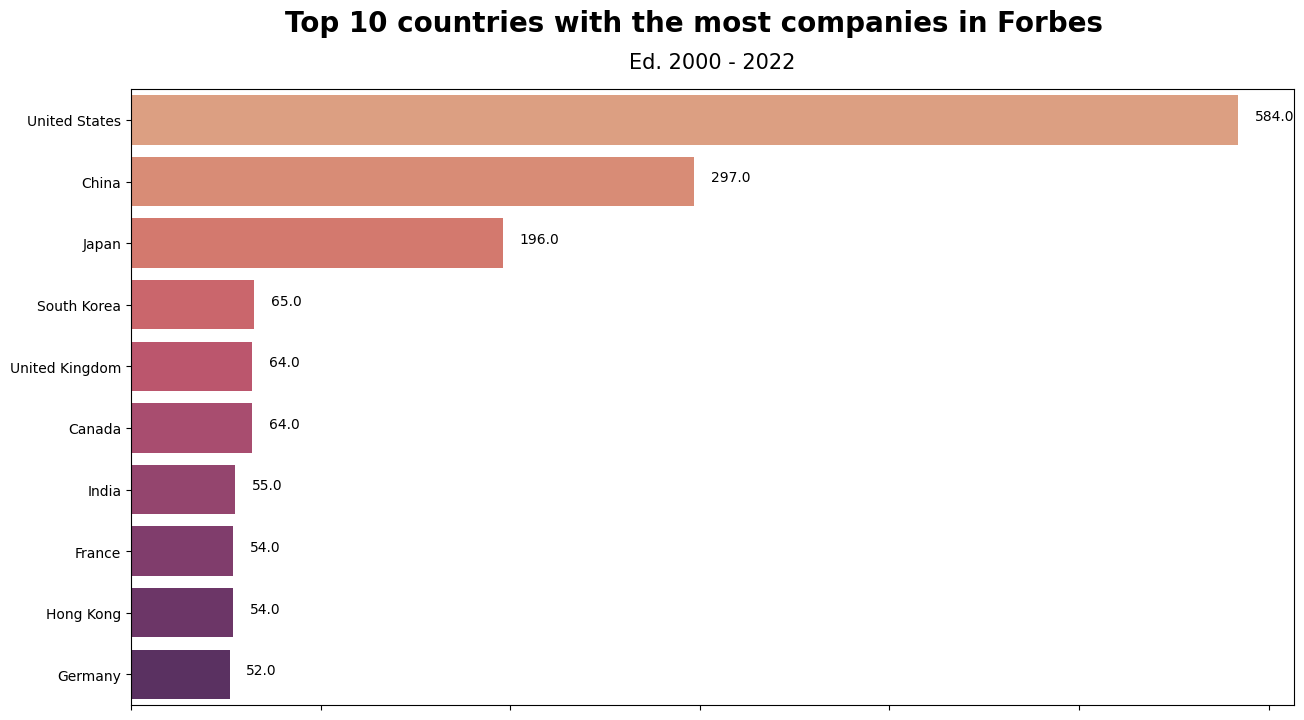

In [ ]:
top_10_countries(data_2022_cont, 'Ed. 2000 - 2022')

2. What is the Top 4 countries with the most companies in the area of technology and telecommunications?

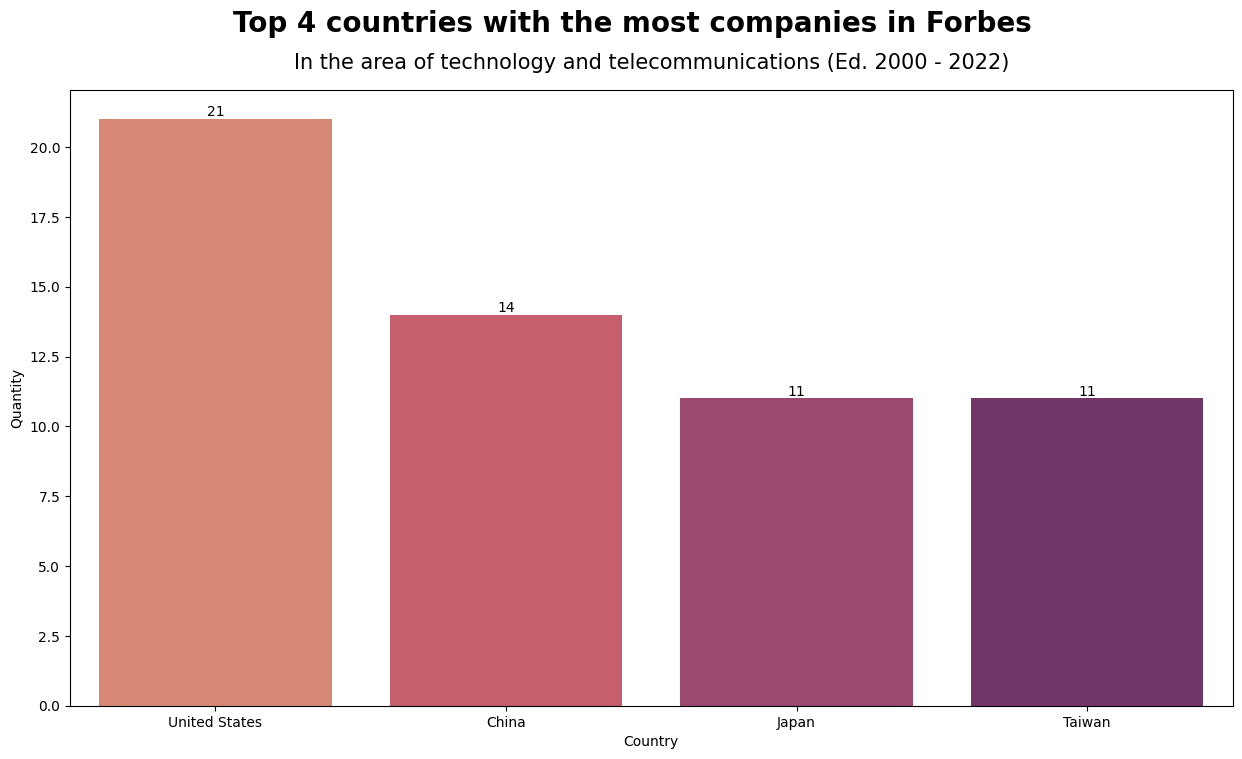

In [ ]:
top_telecom(data_2022_cont, 4,
            'Top 4 countries with the most companies in Forbes',
            'In the area of technology and telecommunications (Ed. 2000 - 2022)')

3. What was the margin of loss of the 5 companies that presented greater damages considering the total losses registered in the Hotel, Restaurant and Entertainment Industry?

<ipython-input-61-7f621cba6434>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_hotel_5['Profit_margin_abs'] = data_hotel_5['Profit margin'].abs()


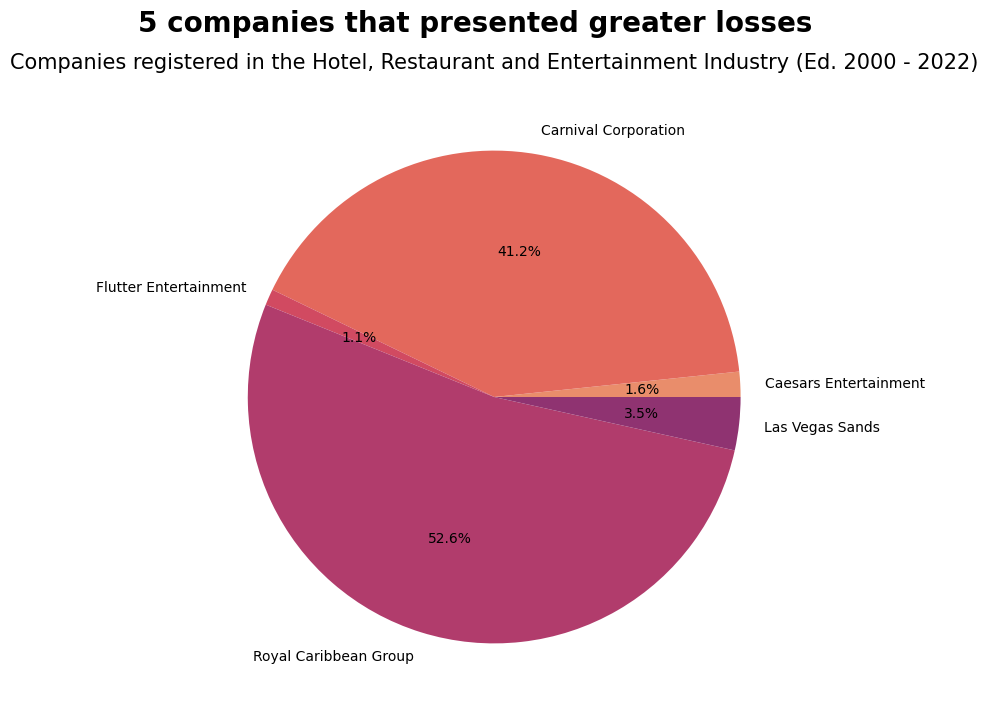

In [ ]:
data_hotel_5 = data_2022_cont[(data_2022_cont['Industry']=='Hotels, Restaurants & Leisure')&
                              (data_2022_cont['Earnings']<0)]

data_hotel_5['Profit_margin_abs'] = data_hotel_5['Profit margin'].abs()

mpl.figure(figsize=(15, 8))

_, _, autopcts=mpl.pie(data_hotel_5['Profit_margin_abs'],
                       labels=data_hotel_5['Company'],
                       autopct='%1.1f%%',
                       colors=sb.color_palette('flare'))

mpl.suptitle('5 companies that presented greater losses',fontsize=20,weight='bold')
mpl.title('Companies registered in the Hotel, Restaurant and Entertainment Industry (Ed. 2000 - 2022)',fontsize=15,pad=15)

mpl.show()

4. Considering the Oil Industry in Asia, which company or companies exceeded their profit margin by more than 20%?

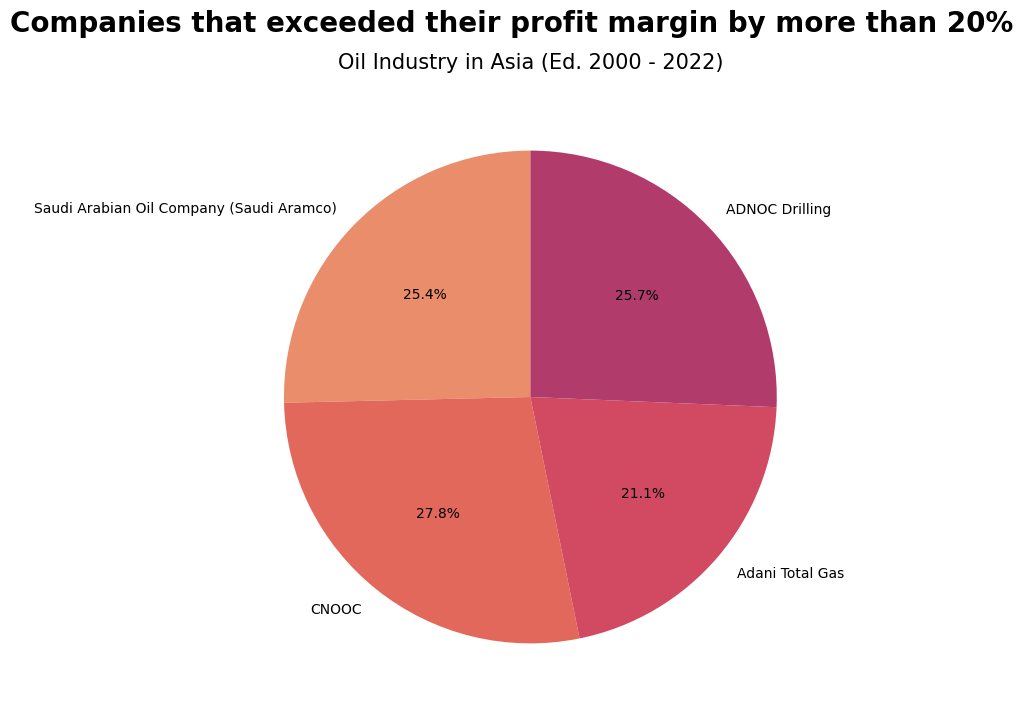

In [ ]:
top_oil_asia = data_2022_cont[(data_2022_cont['Industry'] == 'Oil & Gas Operations')&
                              (data_2022_cont['Continent_Name']=='Asia')]

top_oil_asia = top_oil_asia[top_oil_asia['Profit margin']>0.20]

mpl.figure(figsize=(15, 8))

mpl.pie(top_oil_asia['Profit margin'],
        labels=top_oil_asia['Company'],
        autopct='%1.1f%%',
        startangle=90,
        colors=sb.color_palette('flare'))

mpl.suptitle('Companies that exceeded their profit margin by more than 20%',fontsize=20,weight='bold')
mpl.title('Oil Industry in Asia (Ed. 2000 - 2022)',fontsize=15,pad=15)
mpl.show()

5. Which were the North American companies with the highest percentage of profitability by industry?

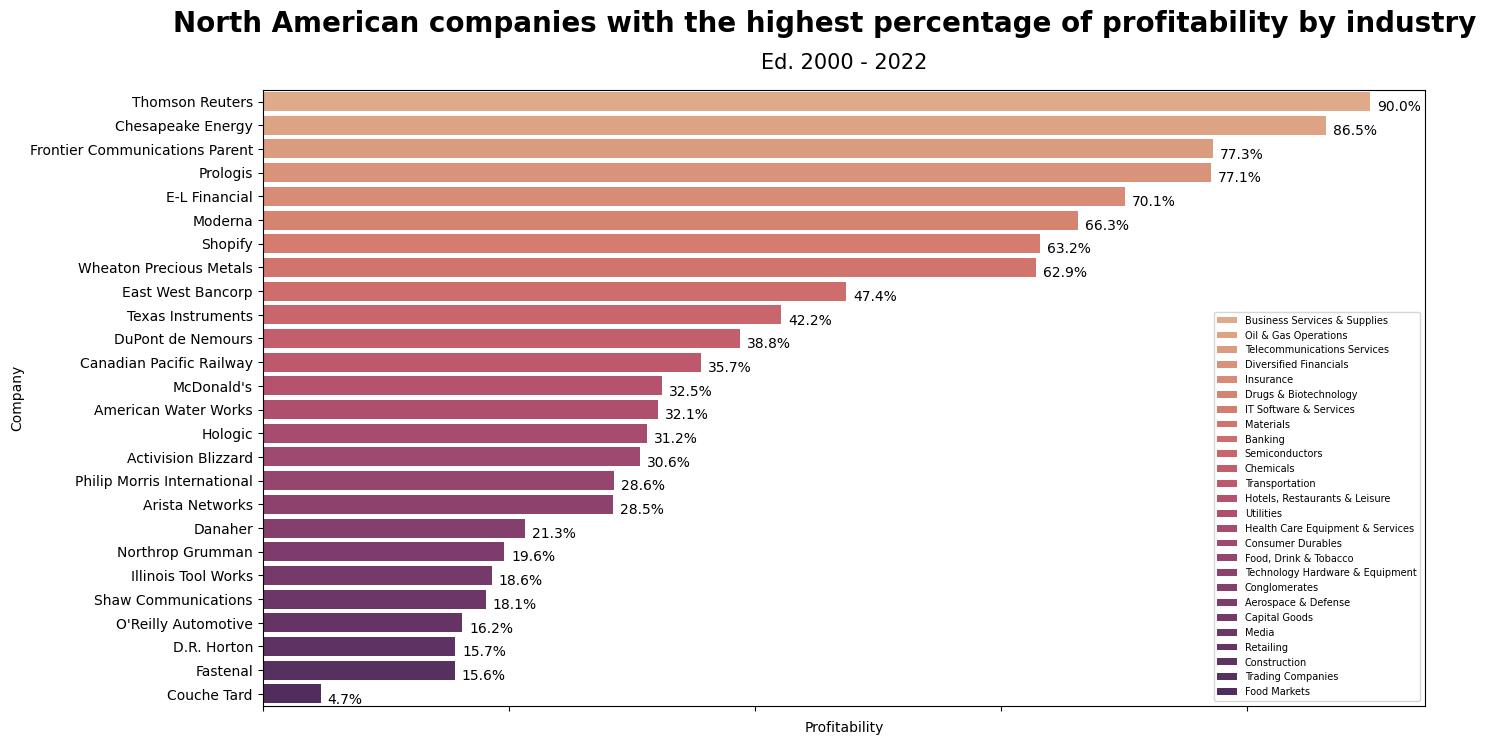

In [ ]:
top_companies_eu_na(data_2022_cont,
                    'North America',
                    'North American companies with the highest percentage of profitability by industry',
                    'Ed. 2000 - 2022')

6. Excluding the banking industry, which were the European companies with the highest losses recorded by industry globally?

<ipython-input-64-15ed8ac3f722>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_loss = no_banking_data[(data_2022_cont['Continent_Name']=='Europe')&


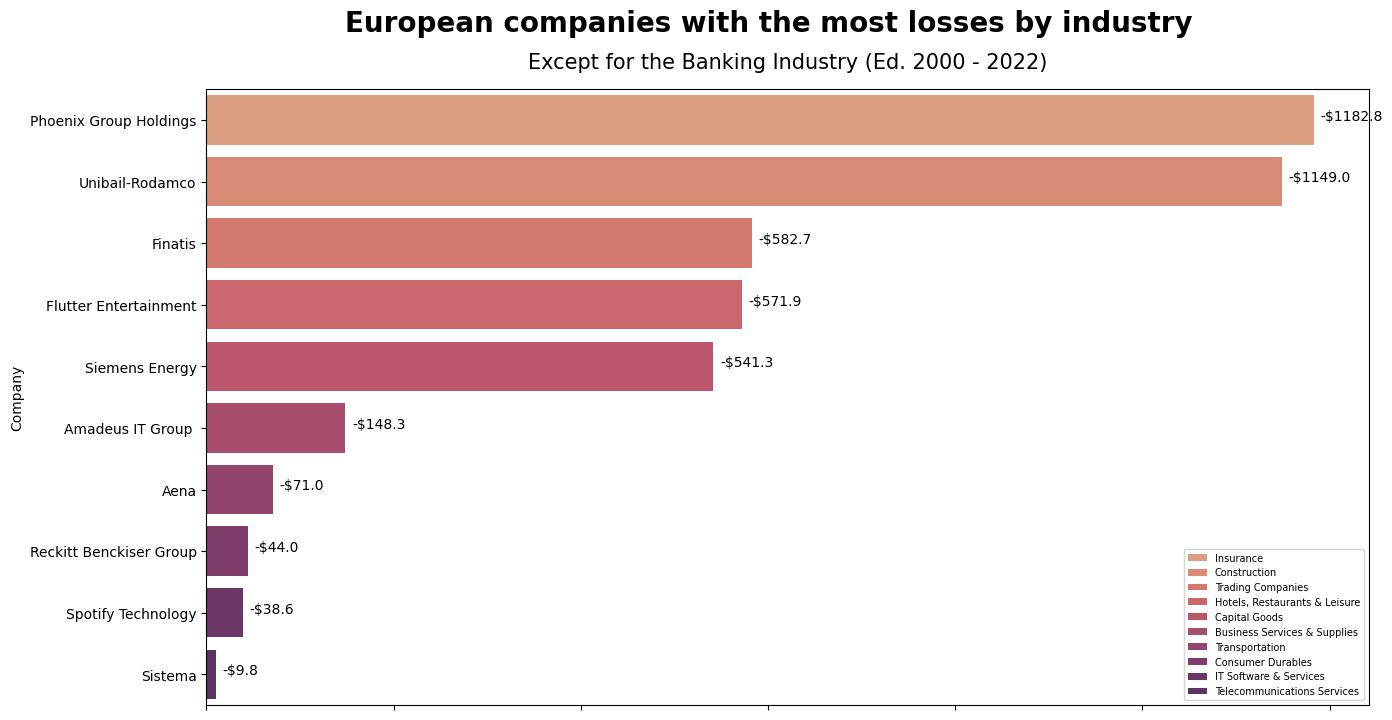

In [ ]:
# Remove the Banking industry and leave the companies that are located in Europe and whose profits are < 0
no_banking_data = data_2022_cont[data_2022_cont['Industry']!='Banking']

data_loss = no_banking_data[(data_2022_cont['Continent_Name']=='Europe')&
                            (data_2022_cont['Earnings']<0)]

icrs_loss = data_loss.groupby('Industry')['Earnings'].idxmax()
loss_company_eu = data_loss.loc[icrs_loss, ['Industry', 'Company', 'Earnings']].sort_values('Earnings')
loss_company_eu['earnings_abs'] = loss_company_eu['Earnings'].abs()

mpl.figure(figsize=(15, 8))

ax=sb.barplot(data=loss_company_eu,
              x='earnings_abs',
              y='Company',
              hue='Industry',
              dodge=False,
              palette='flare')

ax.set_xticklabels([])

mpl.suptitle('European companies with the most losses by industry', fontsize=20,weight='bold')
mpl.title('Except for the Banking Industry (Ed. 2000 - 2022)',fontsize=15,pad=15)
mpl.xlabel('')
mpl.ylabel('Company')

mpl.legend(fontsize=7,loc='lower right')

for p in ax.patches:
    width = p.get_width()
    value = p.get_width()
    x = p.get_x() + width
    y = p.get_y() + p.get_height()/2
    ax.annotate(f'-${value:.1f}', (x, y), xytext=(5, 0), textcoords='offset points')

mpl.show()

7. What was the distribution of Income and Assets with respect to the profits of banks whose assets do not exceed 30000 million dollars?

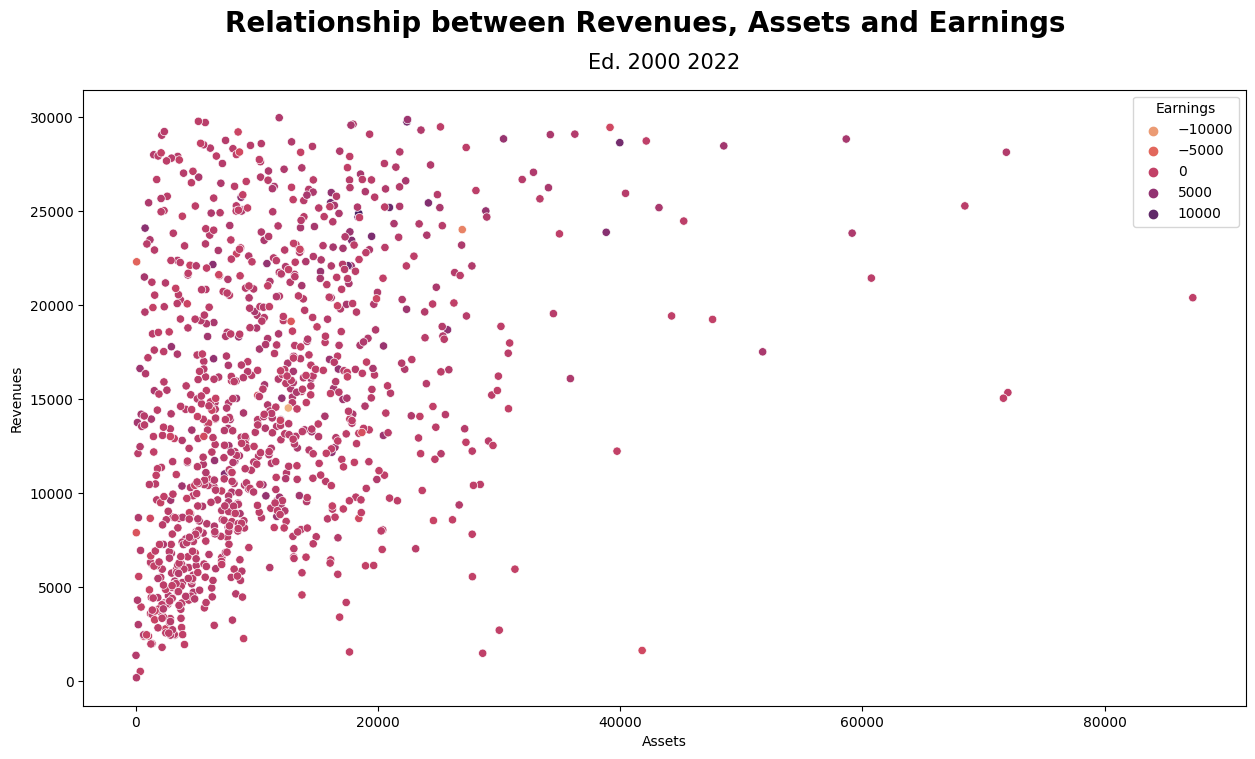

In [ ]:
income_relationship(data_2022_cont, 'Ed. 2000 2022', 30000)

8. Considering the historical values of the shares in the year 2022 of the 5 companies of your choice (Step 2), Indicate which was the best week to buy and which to sell respectively? (Bought when the price is low, and sold when the price is high)

<ipython-input-67-8630bc41ce46>:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  comp_data_weekly = company.groupby(company['datetime'].dt.week)['close'].agg(['min', 'max'])
<ipython-input-67-8630bc41ce46>:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  comp_data_weekly['Date'] = company.groupby(company['datetime'].dt.week)['datetime'].agg(lambda x: f"{x.min().date()} - {x.max().date()}")
<ipython-input-67-8630bc41ce46>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(comp_data_weekly['Date'], rotation=45, ha='right')


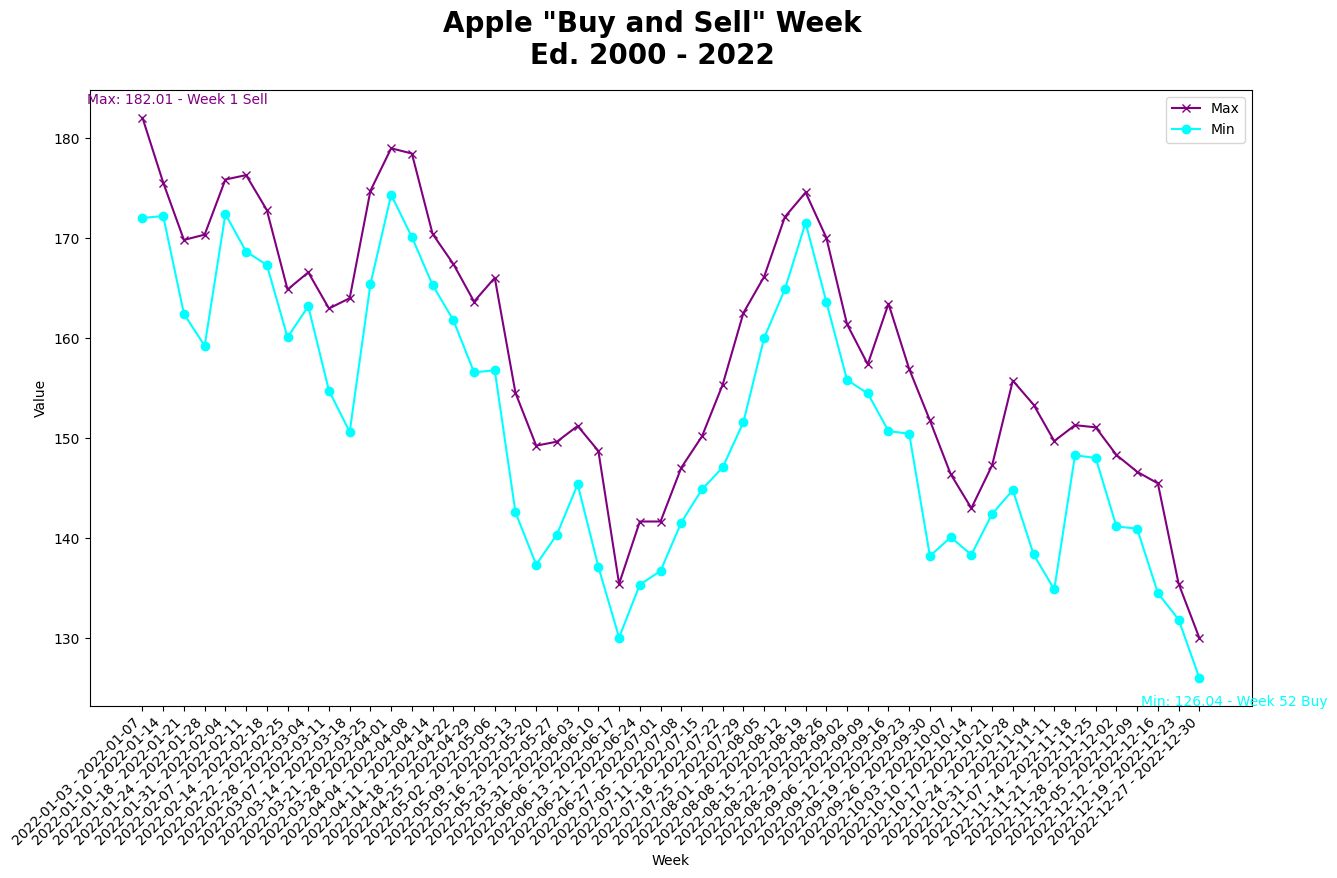

In [ ]:
createChart(apple_data_hist, 'Apple')

<ipython-input-67-8630bc41ce46>:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  comp_data_weekly = company.groupby(company['datetime'].dt.week)['close'].agg(['min', 'max'])
<ipython-input-67-8630bc41ce46>:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  comp_data_weekly['Date'] = company.groupby(company['datetime'].dt.week)['datetime'].agg(lambda x: f"{x.min().date()} - {x.max().date()}")
<ipython-input-67-8630bc41ce46>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(comp_data_weekly['Date'], rotation=45, ha='right')


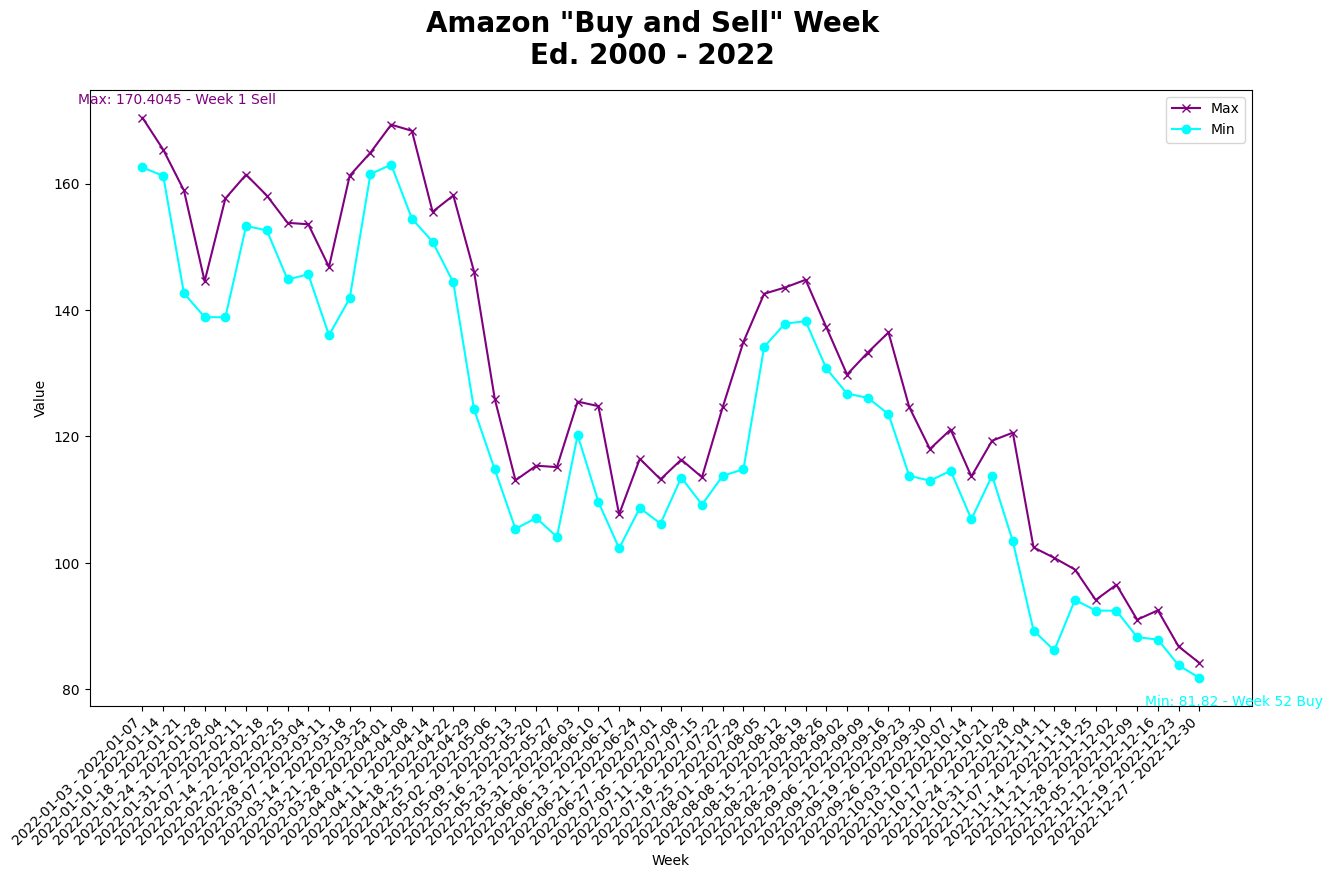

In [ ]:
createChart(amazon_data_hist, 'Amazon')

<ipython-input-67-8630bc41ce46>:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  comp_data_weekly = company.groupby(company['datetime'].dt.week)['close'].agg(['min', 'max'])
<ipython-input-67-8630bc41ce46>:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  comp_data_weekly['Date'] = company.groupby(company['datetime'].dt.week)['datetime'].agg(lambda x: f"{x.min().date()} - {x.max().date()}")
<ipython-input-67-8630bc41ce46>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(comp_data_weekly['Date'], rotation=45, ha='right')


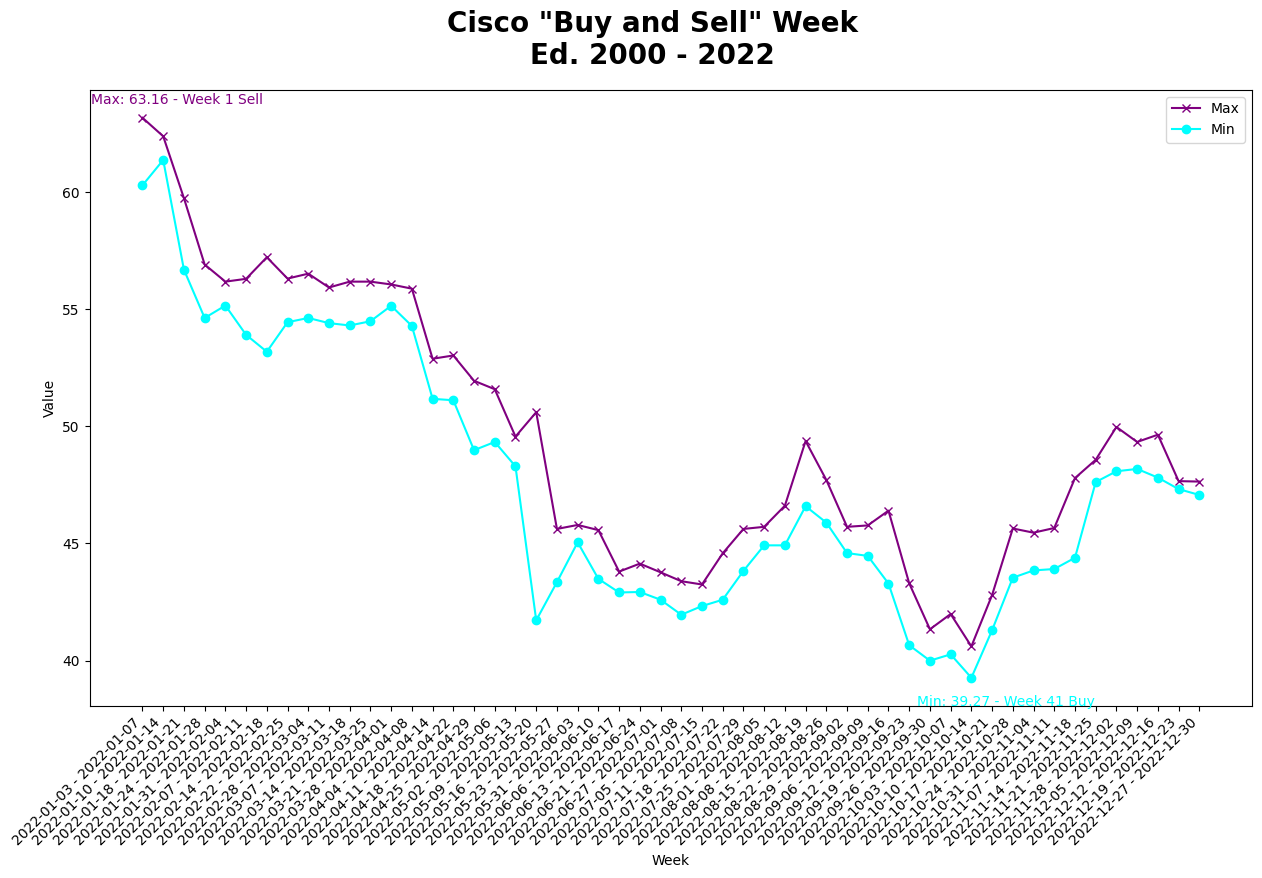

In [ ]:
createChart(cisco_data_hist, 'Cisco')

<ipython-input-67-8630bc41ce46>:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  comp_data_weekly = company.groupby(company['datetime'].dt.week)['close'].agg(['min', 'max'])
<ipython-input-67-8630bc41ce46>:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  comp_data_weekly['Date'] = company.groupby(company['datetime'].dt.week)['datetime'].agg(lambda x: f"{x.min().date()} - {x.max().date()}")
<ipython-input-67-8630bc41ce46>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(comp_data_weekly['Date'], rotation=45, ha='right')


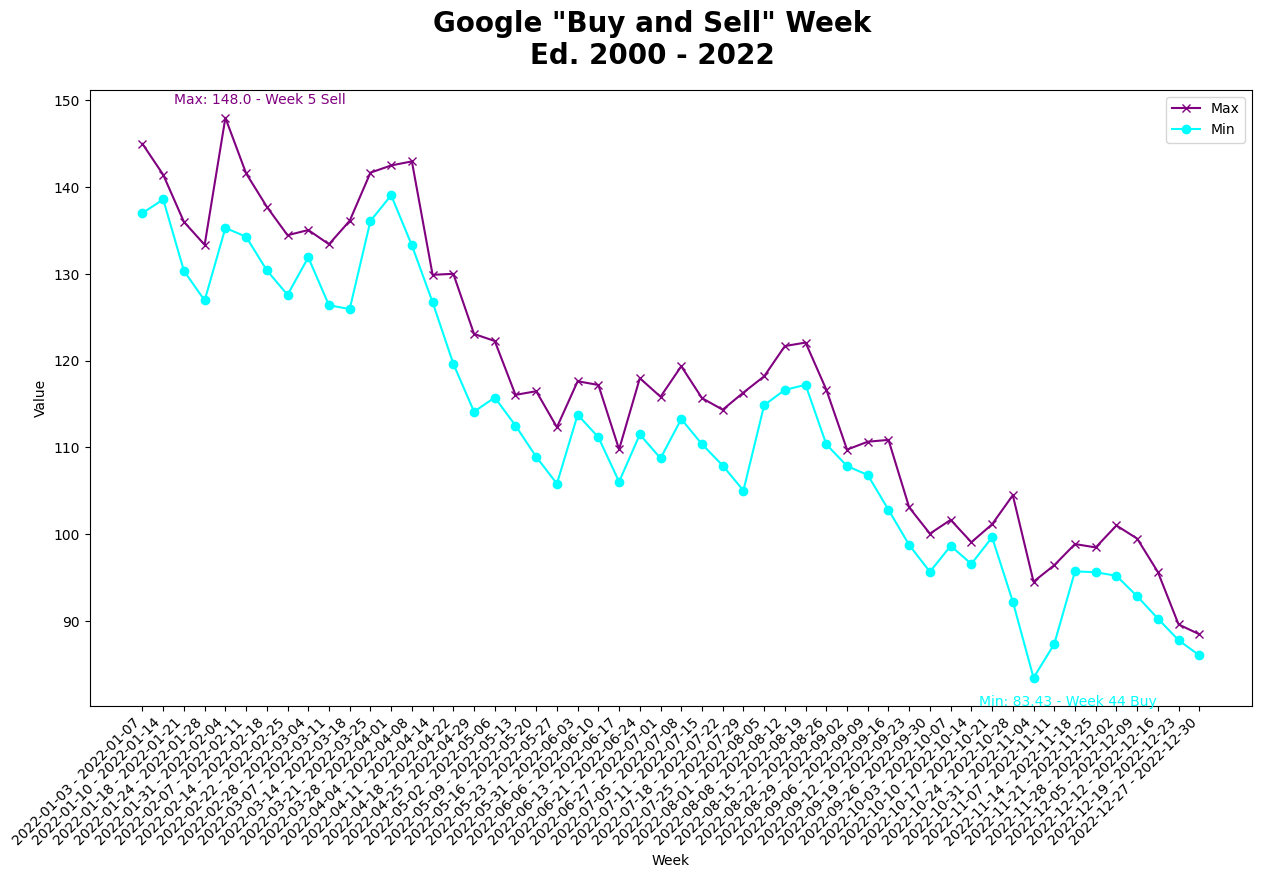

In [ ]:
createChart(google_data_hist, 'Google')

<ipython-input-67-8630bc41ce46>:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  comp_data_weekly = company.groupby(company['datetime'].dt.week)['close'].agg(['min', 'max'])
<ipython-input-67-8630bc41ce46>:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  comp_data_weekly['Date'] = company.groupby(company['datetime'].dt.week)['datetime'].agg(lambda x: f"{x.min().date()} - {x.max().date()}")
<ipython-input-67-8630bc41ce46>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(comp_data_weekly['Date'], rotation=45, ha='right')


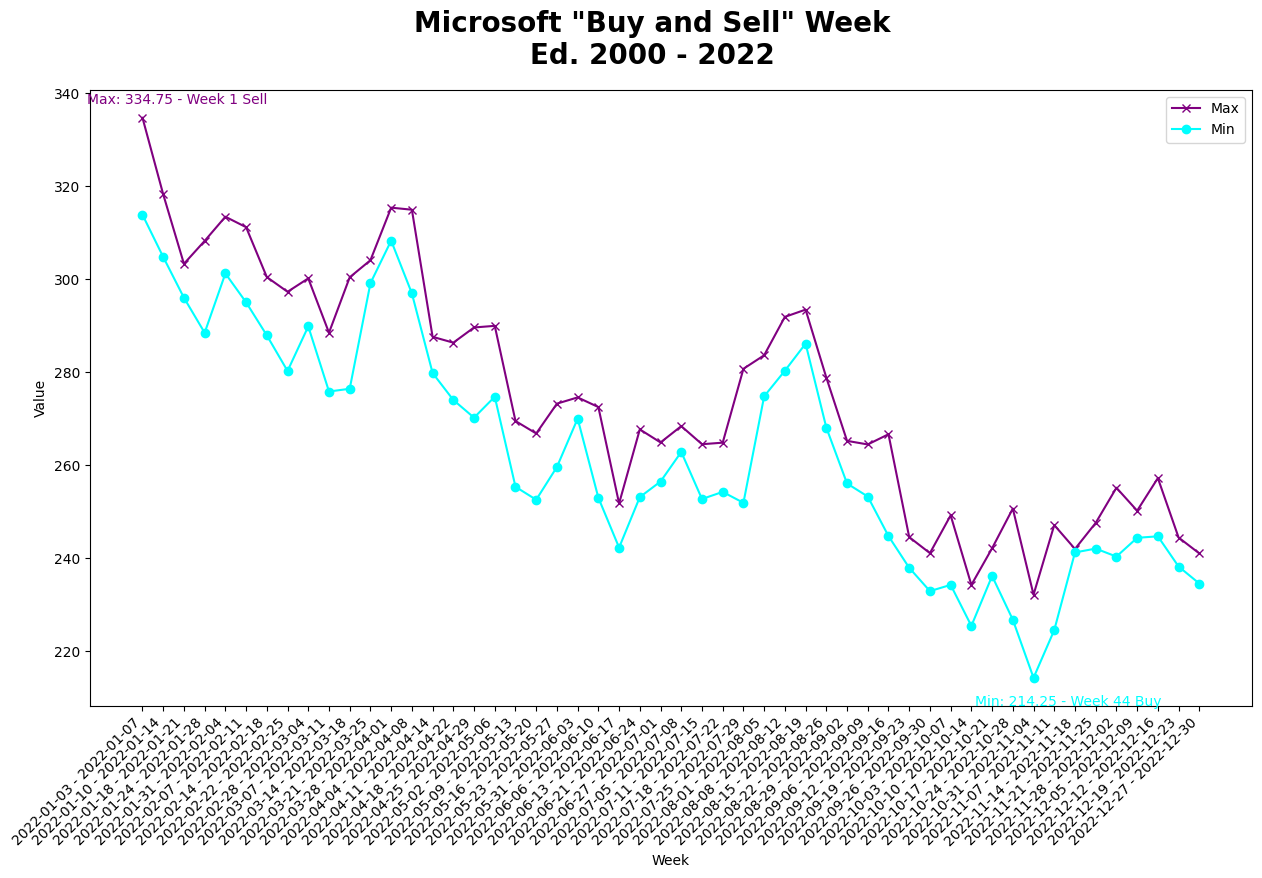

In [ ]:
createChart(microsoft_data_hist, 'Microsoft')

### Questionnaire #2

1. What is the Top 10 countries with the most companies in Forbes for the indicated period (2015 - 2022)?

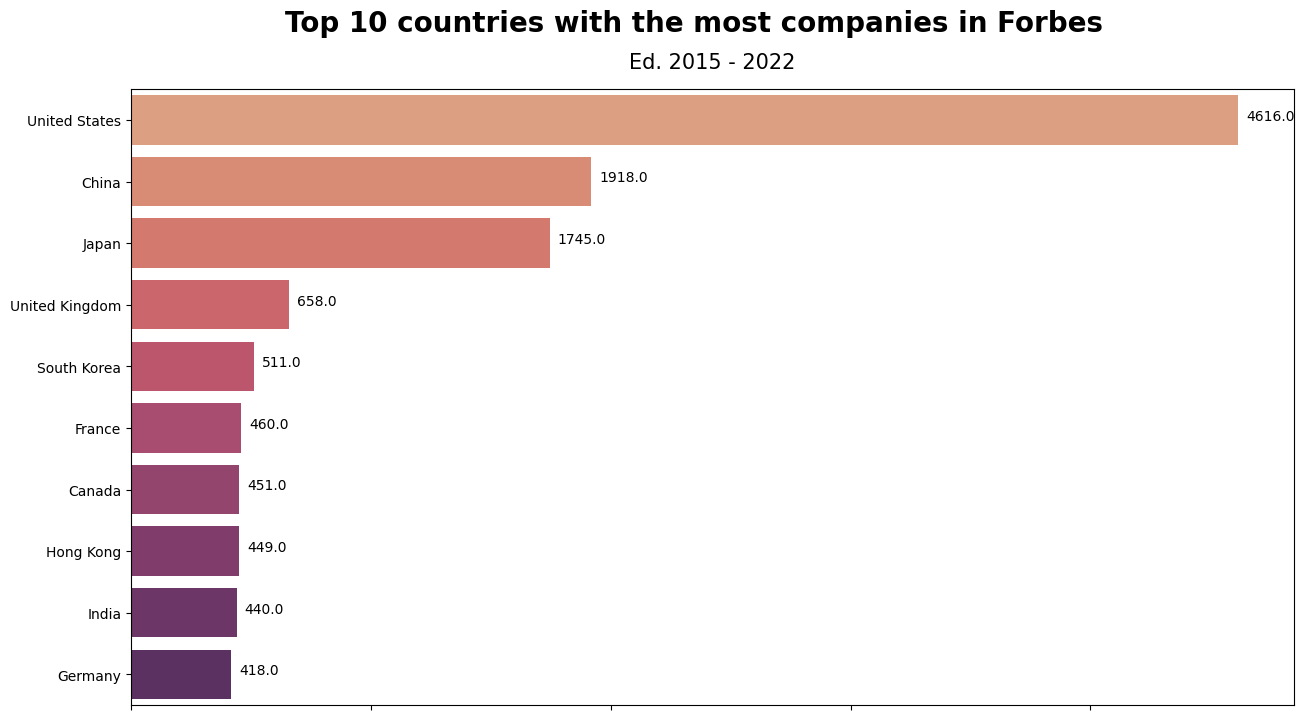

In [ ]:
top_10_countries(data_forbes_def, 'Ed. 2015 - 2022')

2. What is the Top 5 countries with the most companies in the area of technology and telecommunications?

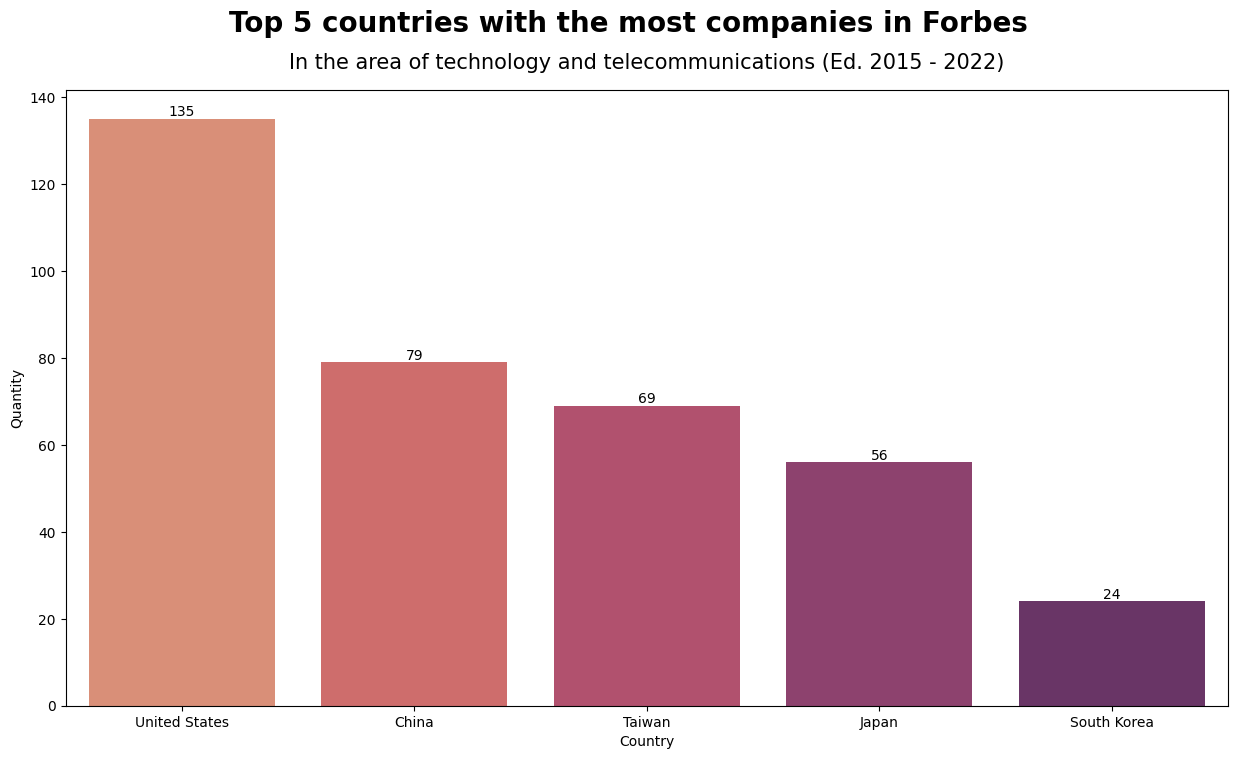

In [ ]:
top_telecom(data_forbes_def, 5,
                'Top 5 countries with the most companies in Forbes',
                'In the area of technology and telecommunications (Ed. 2015 - 2022)')

3. What was the margin of loss of the 10 companies that presented greater damages considering the total losses registered in the Hotel, Restaurant and Entertainment Industry?

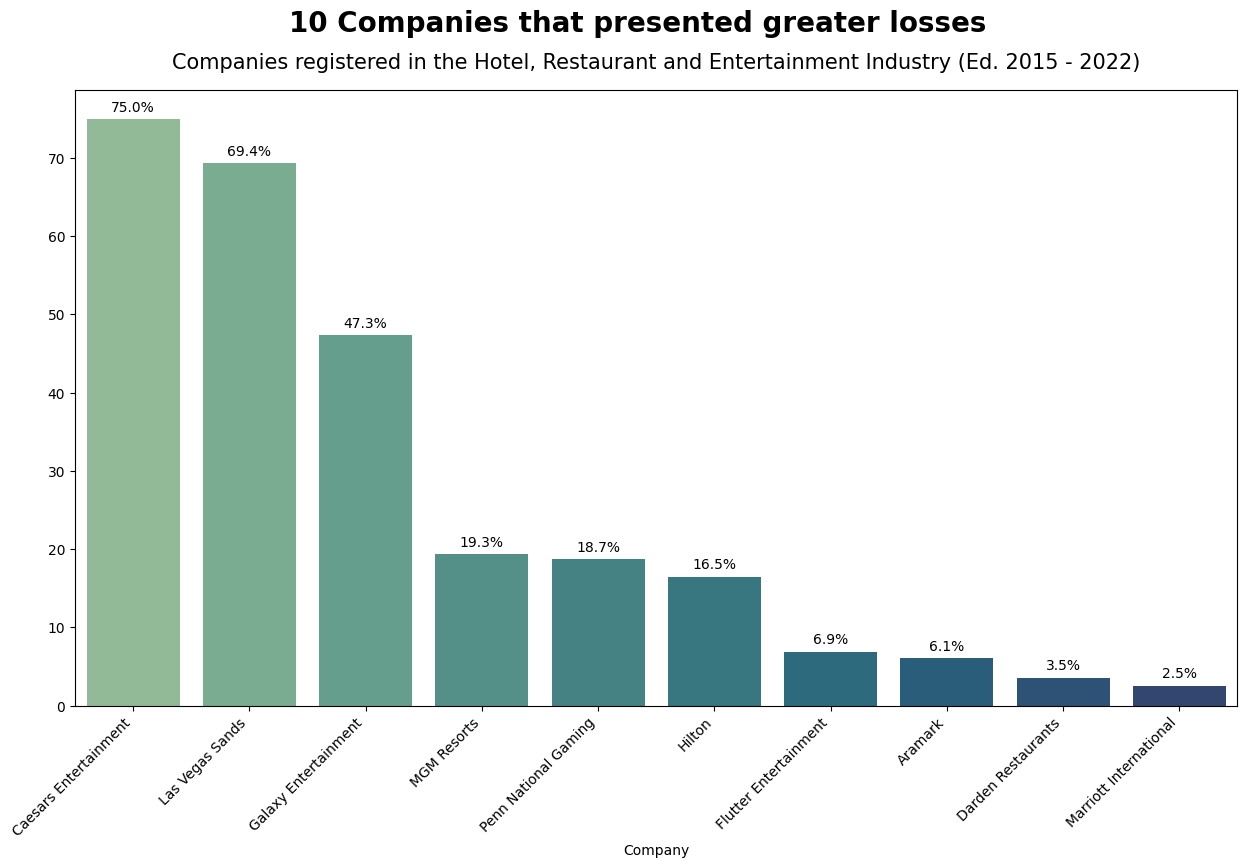

In [ ]:
# Carnival Company should be replaced by Carnival Corporation
data_def['Company'] = data_def['Company'].replace('Carnival', 'Carnival Corporation')

# Filter industry by Hotels, Restaurants and Entertainment and leave earnings < 0
data_hotel_10 = data_def[(data_def['Industry']=='Hotels, Restaurants & Leisure')&
                         (data_def['Earnings']<0)].sort_values('Earnings')

# Absolute profit margin
data_hotel_10['profit_margin_abs']=(data_hotel_10['Profit margin']*100).abs()

# Leave companies that have a profit margin < 100 since having profitability margin >100 is uncommon
data_hotel_10 = data_hotel_10[data_hotel_10['profit_margin_abs']<100]
hotel_profitability_icrsd = data_hotel_10.groupby('Company')['profit_margin_abs'].sum()
hotel_profitability_icrsd = hotel_profitability_icrsd.head(10)

mpl.figure(figsize=(15, 8))
ax=sb.barplot(x=hotel_profitability_icrsd.index,
              y=hotel_profitability_icrsd.values,
              order=hotel_profitability_icrsd.sort_values(ascending=False).index,
              palette='crest',
              saturation=0.75,
              width=0.8)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

mpl.suptitle('10 Companies that presented greater losses',fontsize=20,weight='bold')
mpl.title('Companies registered in the Hotel, Restaurant and Entertainment Industry (Ed. 2015 - 2022)',fontsize=15,pad=15)

for p in ax.patches:
    width = p.get_width()
    value = p.get_height()
    x = p.get_x() + width / 2
    y = p.get_y() + value +1
    ax.annotate(f'{value:.1f}%', (x, y), ha='center')

mpl.show()

4. Considering the Oil Industry in the Americas, which company or companies exceeded the profitability of their assets by more than 20%?

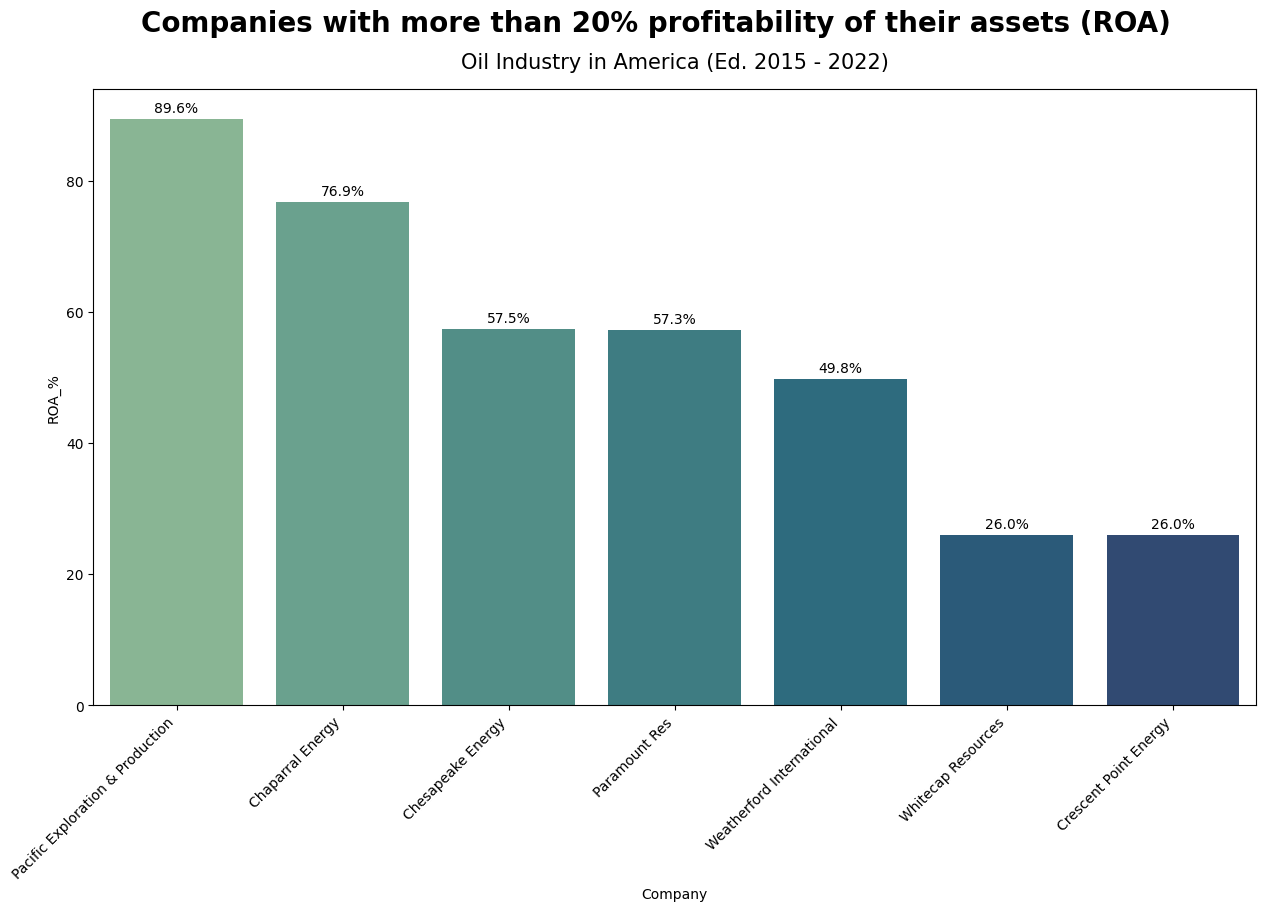

In [ ]:
# Filter Oil industry and leave ROA < 1
top_oil_america = data_def[(data_def['Industry'] == 'Oil & Gas Operations')&
                           (data_def['ROA']<1)&
                           ((data_def['Continent_Name']=='North America')|
                            (data_def['Continent_Name']=='South America'))].sort_values(by='ROA',ascending=False)

top_oil_america = top_oil_america.query('ROA>0.2')
top_oil_america['ROA_%'] = top_oil_america['ROA']*100

mpl.figure(figsize=(15, 8))

ax=sb.barplot(x=top_oil_america['Company'],
              y=top_oil_america['ROA_%'],
              palette='crest',
              saturation=0.75,
              width=0.8)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

mpl.suptitle('Companies with more than 20% profitability of their assets (ROA)',fontsize=20,weight='bold')
mpl.title('Oil Industry in America (Ed. 2015 - 2022)',fontsize=15,pad=15)

for p in ax.patches:
    width = p.get_width()
    value = p.get_height()
    x = p.get_x() + width / 2
    y = p.get_y() + value +1
    ax.annotate(f'{value:.1f}%', (x, y), ha='center')

mpl.show()

5. Which were the European companies with the highest percentage of profitability by industry?

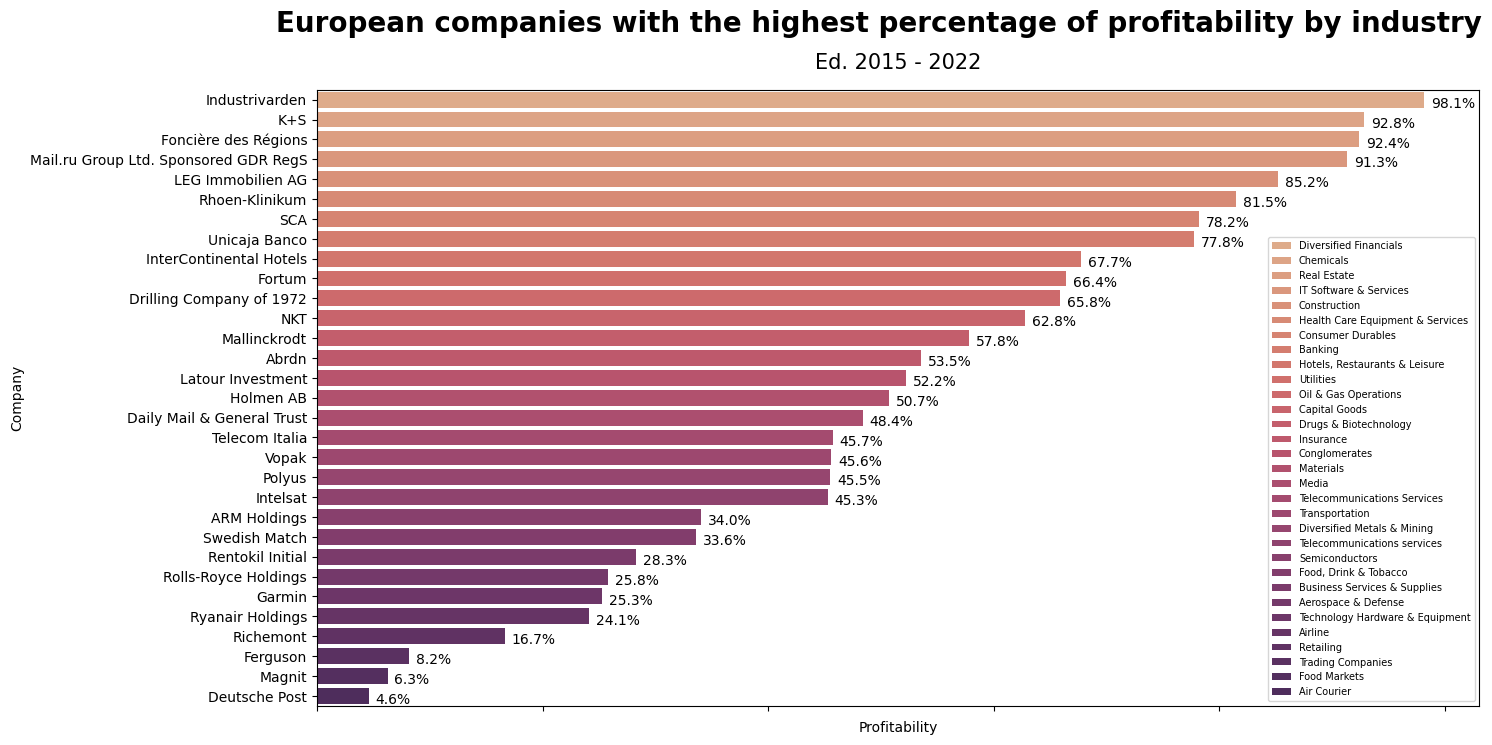

In [ ]:
top_companies_eu_na(data_def,
                    'Europe',
                    'European companies with the highest percentage of profitability by industry',
                    'Ed. 2015 - 2022')

6. What were the 10 North American companies with the highest losses recorded by industry globally?

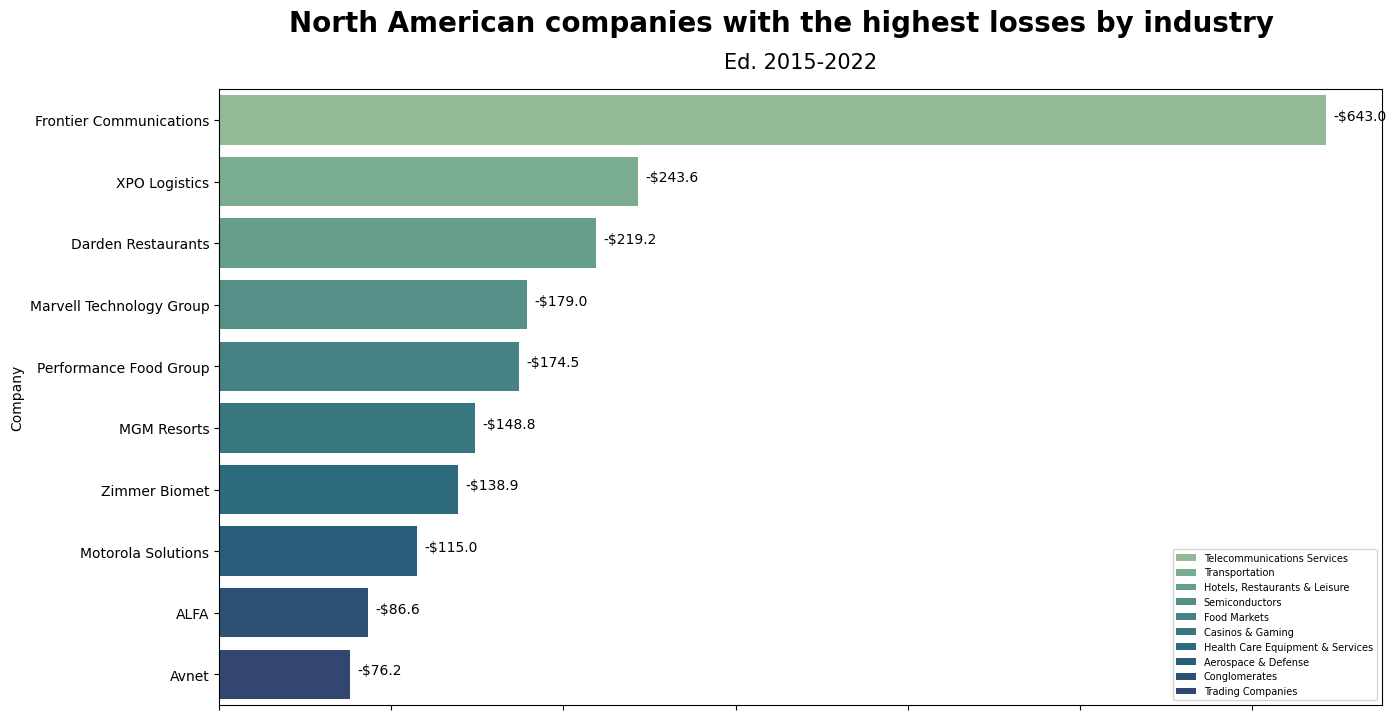

In [ ]:
# Filter North America and leave earnings < 0
n_america_data = data_forbes_def[(data_forbes_def['Continent_Name']=='North America')&
                                 (data_forbes_def['Earnings']<0)]

hgst_loss = n_america_data.groupby('Industry')['Earnings'].idxmax()
loss_company_na = n_america_data.loc[hgst_loss, ['Industry', 'Company', 'Earnings']].sort_values('Earnings').head(10)
loss_company_na['earnings_abs']=loss_company_na['Earnings'].abs()

mpl.figure(figsize=(15, 8))

ax=sb.barplot(data=loss_company_na,
              x='earnings_abs',
              y='Company',
              hue='Industry',
              dodge=False,
              palette='crest')

ax.set_xticklabels([])

mpl.suptitle('North American companies with the highest losses by industry',fontsize=20,weight='bold')
mpl.title('Ed. 2015-2022',fontsize=15,pad=15)
mpl.xlabel('')
mpl.ylabel('Company')

mpl.legend(fontsize=7,loc='lower right')

for p in ax.patches:
    width = p.get_width()
    value = p.get_width()
    x = p.get_x() + width
    y = p.get_y() + p.get_height()/2
    ax.annotate(f'-${value:.1f}', (x, y), xytext=(5, 0), textcoords='offset points')

mpl.show()


7. What was the distribution of Income and Assets with respect to the profits of banks whose assets do not exceed 15000 million dollars?

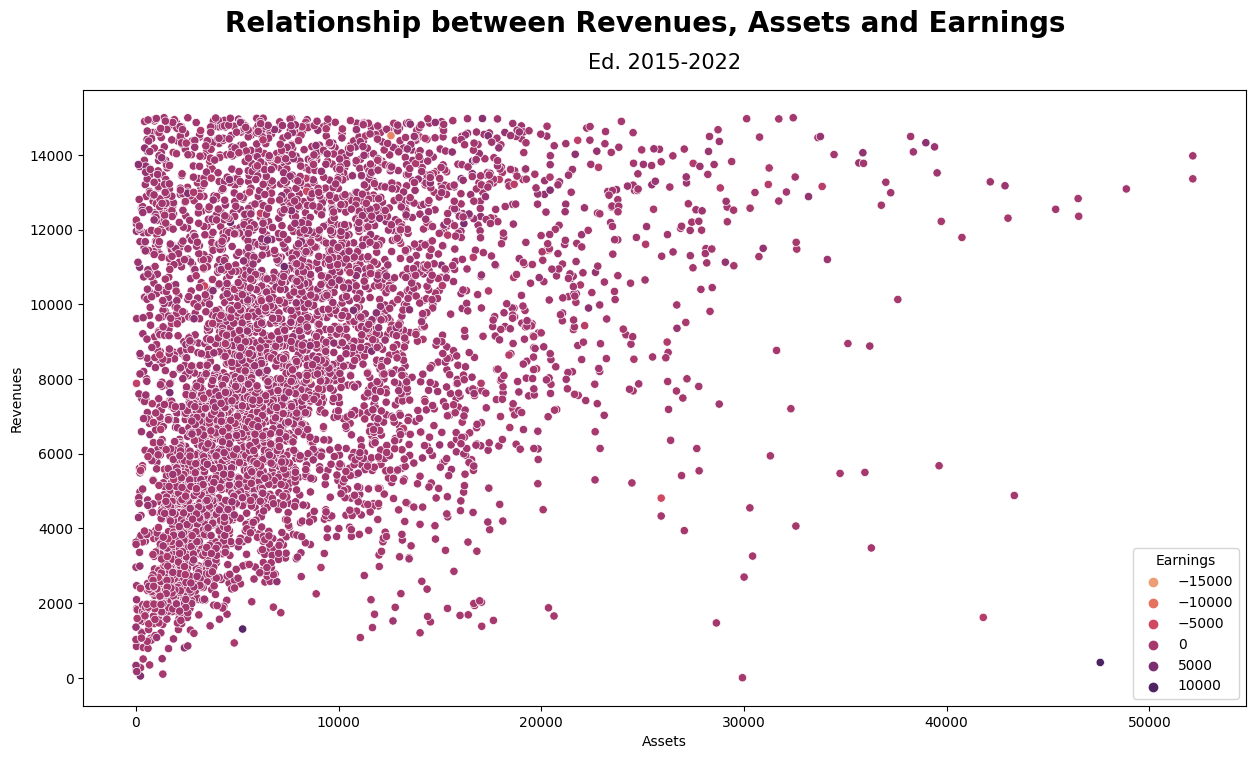

In [ ]:
income_relationship(data_def, 'Ed. 2015-2022', 15000)

8. What were the annual profits of the major companies in the automotive industry?

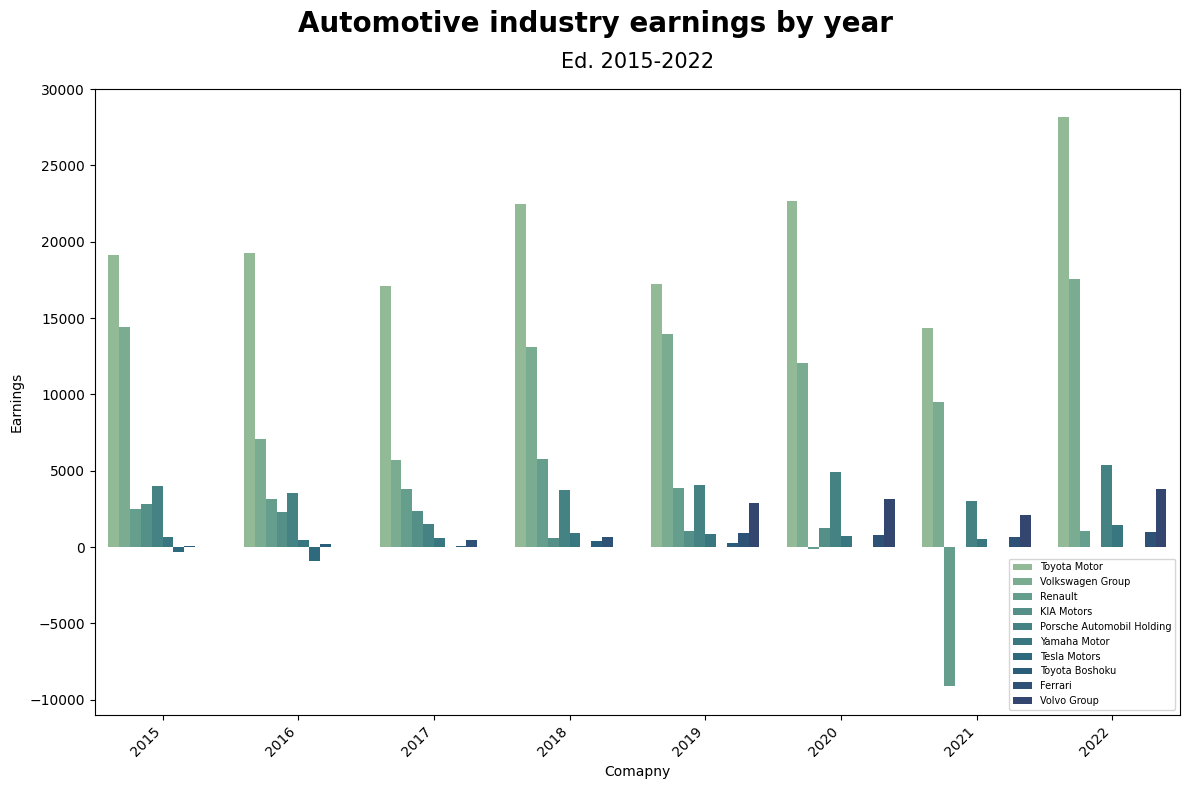

In [ ]:
car_companies = ['Toyota Motor',
                 'Volkswagen Group',
                 'Toyota Boshoku',
                 'Tesla Motors',
                 'Yamaha Motor',
                 'Volvo Group',
                 'Ferrari',
                 'Renault',
                 'Porsche Automobil Holding',
                 'KIA Motors']

car_data_earnings = data_def[(data_def['Industry']=='Consumer Durables')&
                             (data_def['Company'].isin(car_companies))]

mpl.figure(figsize=(12, 8))

ax=sb.barplot(data = car_data_earnings,
              x='Year',
              y='Earnings',
              hue='Company',
              palette='crest')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
mpl.suptitle('Automotive industry earnings by year',fontsize=20,weight='bold')
mpl.title('Ed. 2015-2022',fontsize=15,pad=15)
mpl.xlabel('Comapny')
mpl.ylabel('Earnings')

mpl.legend(loc='lower right',fontsize=7)
mpl.tight_layout()

mpl.show()

## Extra Visualizations and Animations

### Racing Bar Chart

1. Create a racing bar chart that indicates the variation of the market value by industry during the period 2015 - 2022.

In [ ]:
racing_chart(data_def,
             'Market value',
             'Variation of the Market Value of each industry (Ed. 2015-2022)')

/usr/local/lib/python3.10/dist-packages/bar_chart_race/_make_chart.py:286: UserWarning:

FixedFormatter should only be used together with FixedLocator

/usr/local/lib/python3.10/dist-packages/bar_chart_race/_make_chart.py:287: UserWarning:

FixedFormatter should only be used together with FixedLocator



2. Create another bar race chart showing the variation in the number of employees by industry during the period 2015 - 2022.

In [ ]:
racing_chart(data_def,
             'Employees',
             'Variation of employees in each industry (Ed. 2015-2022)')

/usr/local/lib/python3.10/dist-packages/bar_chart_race/_make_chart.py:286: UserWarning:

FixedFormatter should only be used together with FixedLocator

/usr/local/lib/python3.10/dist-packages/bar_chart_race/_make_chart.py:287: UserWarning:

FixedFormatter should only be used together with FixedLocator



### Map

3. Using the Plotly library, generate a map with the total global sales by country in the year 2020

In [ ]:
data_year = data_def[data_def['Year'] == 2020]
data_grouped = data_year.groupby(['Country','Code'])['Revenues'].sum().reset_index()

min_value = data_year['Revenues'].min()
max_value = data_year['Revenues'].max()

fig = pgo.Figure(data=pgo.Choropleth(locations=data_grouped['Code'],
                                     z=data_grouped['Revenues'],
                                     text=data_grouped['Country'],
                                     colorscale='plotly3',
                                     autocolorscale=True,
                                     reversescale=True,
                                     marker_line_color='darkgray',
                                     marker_line_width=2,
                                     colorbar_tickprefix='$',
                                     colorbar_title='US$',
                                     zmin=min_value,
                                     zmax=max_value))

fig.update_geos(resolution=50,
                showcountries=True,
                showcoastlines=True,
                coastlinecolor='darkgray',
                projection_type='equirectangular',
                lonaxis_range=[-180, 180],
                lataxis_range=[-90, 90],
                fitbounds='locations')

fig.update_layout(title_text='Global sales by country in the year 2020',
                  width=1650,
                  height=850,
                  annotations=[dict(x=0.55,
                                    y=0.1,
                                    xref='paper',
                                    yref='paper',
                                    text='Source: Fortune Global 2000',
                                    showarrow=False)])

fig.show()